In [10]:
# !pip install --upgrade pip
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install monai==1.1.0 scikit-image scikit-learn pandas tqdm matplotlib seaborn SimpleITK nibabel matplotlib pydicom

In [2]:
# Cell 1 - run once
# Uncomment if libs missing
# !pip install -U monai==1.1.0 torch torchvision simpleitk matplotlib tqdm
import warnings
warnings.filterwarnings('ignore')

import os, sys, time, math
from pathlib import Path
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    Spacingd, Resized, RandFlipd, RandRotate90d, ToTensord
)
from monai.data import CacheDataset, Dataset
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss

import SimpleITK as sitk

In [3]:
def fix_path(p):
    # normalize slashes
    p = str(p).replace("\\", "/")
    # take only the part AFTER "preprocessed_fleischner/"
    if "preprocessed_fleischner_fixed/" in p:
        p = p.split("preprocessed_fleischner_fixed/")[1]
    # rebuild absolute path
    return f"../dataset/{p}"

In [4]:
# Cell 2
OUTPUT_DIR = Path("../models/3d_unet")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEG_META_PATH = "../metadata/metadata.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load metadata quickly for inspection
# meta = pd.read_csv(META_PATH)
seg_meta = pd.read_csv(SEG_META_PATH)

seg_meta["image"] = seg_meta["image"].apply(fix_path)
seg_meta["mask"]  = seg_meta["mask"].apply(fix_path)

print("Total meta seg rows:", len(seg_meta))


Device: cuda
Total meta seg rows: 1185


In [5]:
seg_meta

,uid,image,mask,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,18.545150
...,...,...,...,...
1180,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,5.053694
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.556101
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.357368
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,4.277203


In [6]:
# Cell 3
# MONAI expects dict entries e.g. {'image': path, 'mask': path}
seg_df = seg_meta.copy()
print(seg_df[["image","mask"]].iloc[0].to_dict())


{'image': '../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279_6001_100225287222365663678666836860_0000.nii.gz', 'mask': '../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_6001_100225287222365663678666836860_0000_mask.nii.gz'}


In [7]:
# Cell 4
# Use Resized to enforce cubic shape in loader so DataLoader stacking is always possible
train_trans = Compose([
    LoadImaged(keys=["image","mask"]),
    EnsureChannelFirstd(keys=["image","mask"]),
    # Optional: if you want to force 1mm spacing, keep Spacingd; else remove it
    # Spacingd(keys=["image","mask"], pixdim=(1.0,1.0,1.0), mode=("bilinear","nearest")),

    # Important: intensity scaling from HU to [0,1] if your saved patches are HU
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000.0, a_max=400.0,
        b_min=0.0, b_max=1.0, clip=True
    ),

    # Force uniform shape 64x64x64 for both image & mask
    Resized(
    keys=["image"],
    spatial_size=(64, 64, 64),
    mode="trilinear"
        ),
        
    Resized(
    keys=["mask"],
    spatial_size=(64, 64, 64),
    mode="nearest"
    ),


    # Augmentations
    RandFlipd(keys=["image","mask"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image","mask"], prob=0.5, spatial_axes=(0,1)),

    ToTensord(keys=["image","mask"])
])

val_trans = Compose([
    LoadImaged(keys=["image","mask"]),
    EnsureChannelFirstd(keys=["image","mask"]),
    ScaleIntensityRanged(keys=["image"], a_min=-1000.0, a_max=400.0, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image","mask"], spatial_size=(64,64,64), mode=("trilinear","nearest")),
    ToTensord(keys=["image","mask"])
])

In [ ]:
# Cell 5
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(seg_df, test_size=0.2, random_state=42, shuffle=True)
print("Train:", len(train_df), "Val:", len(val_df))

train_ds = CacheDataset(data=train_df.to_dict("records"), transform=train_trans, cache_rate=1.0)
val_ds   = CacheDataset(data=val_df.to_dict("records"), transform=val_trans, cache_rate=1.0)

# If memory is low, set cache_rate=0.2 or use monai.data.Dataset instead
print("CacheDataset created. Train size:", len(train_ds), "Val size:", len(val_ds))


Train: 948 Val: 237


Loading dataset:  95%|█████████▌| 226/237 [00:04<00:00, 50.64it/s]

In [9]:
# Cell 6
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)

In [10]:
# Cell 7
unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16,32,64,128),
    strides=(2,2,2),
    num_res_units=2
).to(device)

# Stable loss: dice + BCEWithLogits
bce = torch.nn.BCEWithLogitsLoss()
dice = DiceLoss(sigmoid=True)   # from monai.losses
def combined_loss(pred, target, bce_w=0.5):
    l_d = dice(pred, target)
    l_b = bce(pred, target)
    return bce_w * l_b + (1.0 - bce_w) * l_d

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

dice_metric = DiceMetric(include_background=False, reduction="mean")


In [11]:
def show_prediction(img, mask, pred, slice_idx=None):
    """
    img, mask, pred are tensors of shape (1,64,64,64)
    """

    img  = img.squeeze(0).cpu().numpy()   # (64,64,64)
    mask = mask.squeeze(0).cpu().numpy()
    pred = pred.squeeze(0).cpu().numpy()

    if slice_idx is None:
        slice_idx = img.shape[0] // 2

    fig, ax = plt.subplots(1,3, figsize=(14,4))

    ax[0].imshow(img[slice_idx], cmap="gray")
    ax[0].set_title("Image")

    ax[1].imshow(img[slice_idx], cmap="gray")
    ax[1].imshow(mask[slice_idx], cmap="Reds", alpha=0.5)
    ax[1].set_title("GT Mask")

    ax[2].imshow(img[slice_idx], cmap="gray")
    ax[2].imshow(pred[slice_idx], cmap="Blues", alpha=0.5)
    ax[2].set_title("Pred Mask")

    plt.show()


Epoch 1 val: 100%|██████████| 109/109 [00:06<00:00, 18.00it/s]


Epoch 1/60 | TrainLoss=0.8508 | ValDice=0.0054 | time=27.7s | LR=0.0001


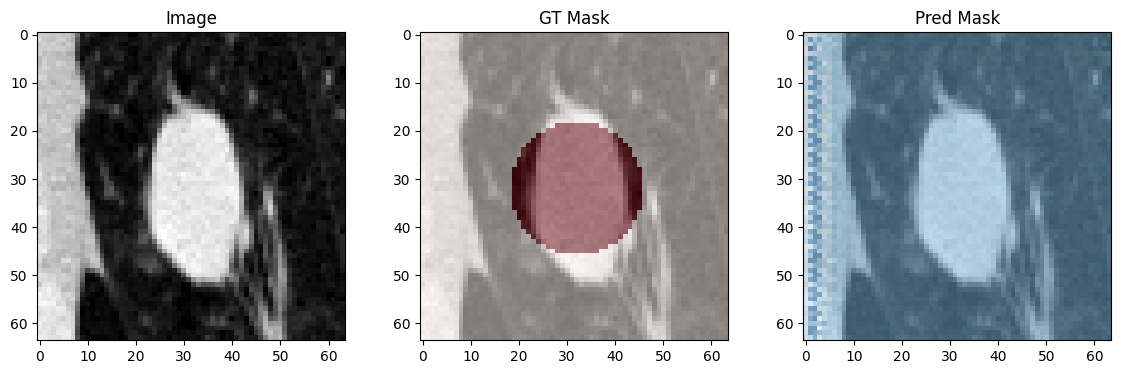

Saved NEW BEST model (val dice improved)


Epoch 2 val: 100%|██████████| 109/109 [00:04<00:00, 23.31it/s]


Epoch 2/60 | TrainLoss=0.7887 | ValDice=0.0079 | time=25.3s | LR=0.0001


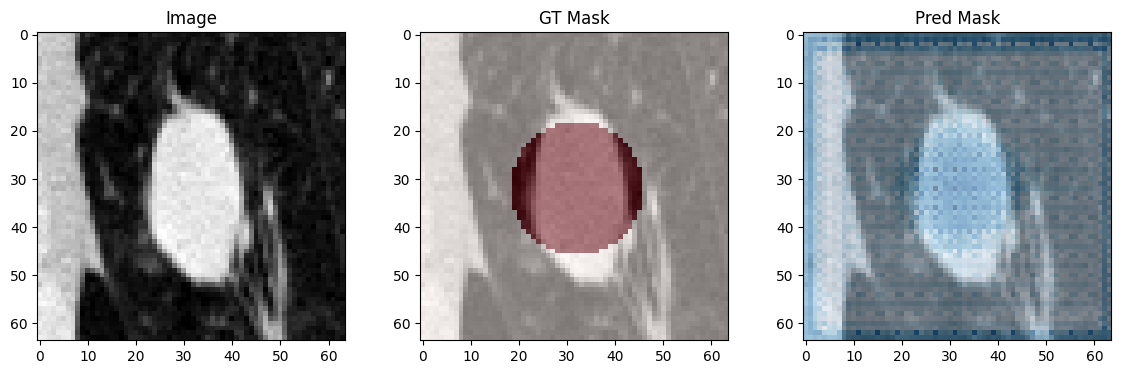

Saved NEW BEST model (val dice improved)


Epoch 3 val: 100%|██████████| 109/109 [00:04<00:00, 22.51it/s]


Epoch 3/60 | TrainLoss=0.6614 | ValDice=0.0106 | time=26.5s | LR=0.0001


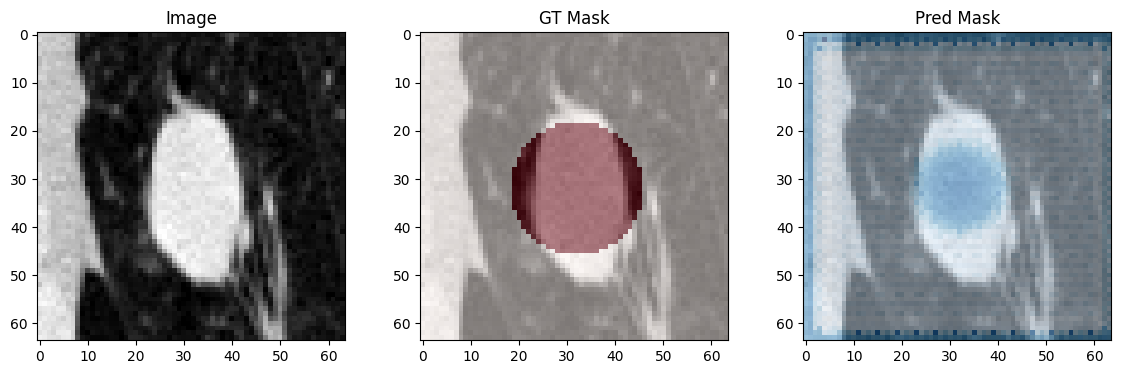

Saved NEW BEST model (val dice improved)


Epoch 4 val: 100%|██████████| 109/109 [00:05<00:00, 21.62it/s]


Epoch 4/60 | TrainLoss=0.6035 | ValDice=0.0138 | time=25.6s | LR=0.0001


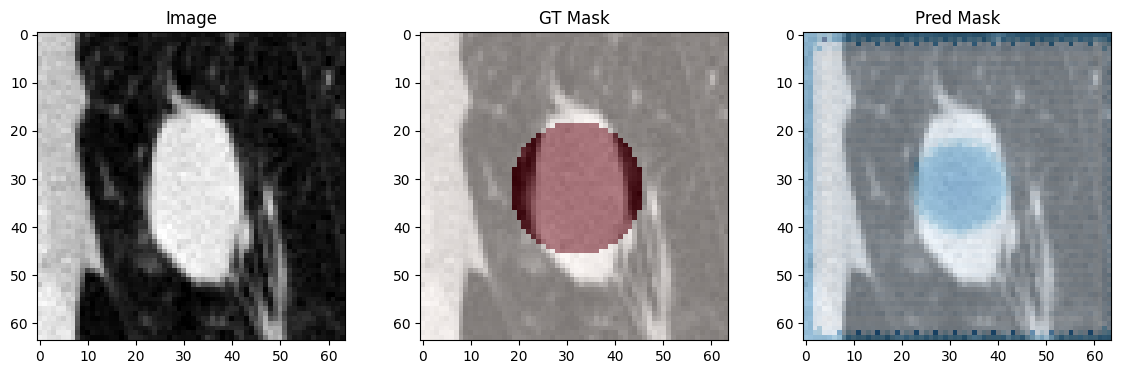

Saved NEW BEST model (val dice improved)


Epoch 5 val: 100%|██████████| 109/109 [00:04<00:00, 22.36it/s]


Epoch 5/60 | TrainLoss=0.5702 | ValDice=0.0158 | time=25.9s | LR=0.0001


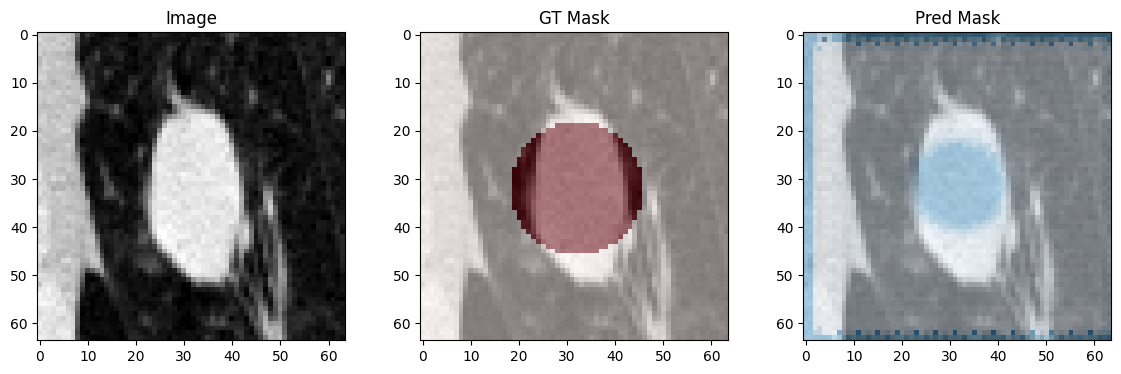

Saved NEW BEST model (val dice improved)


Epoch 6 val: 100%|██████████| 109/109 [00:04<00:00, 22.18it/s]


Epoch 6/60 | TrainLoss=0.5473 | ValDice=0.0197 | time=25.9s | LR=0.0001


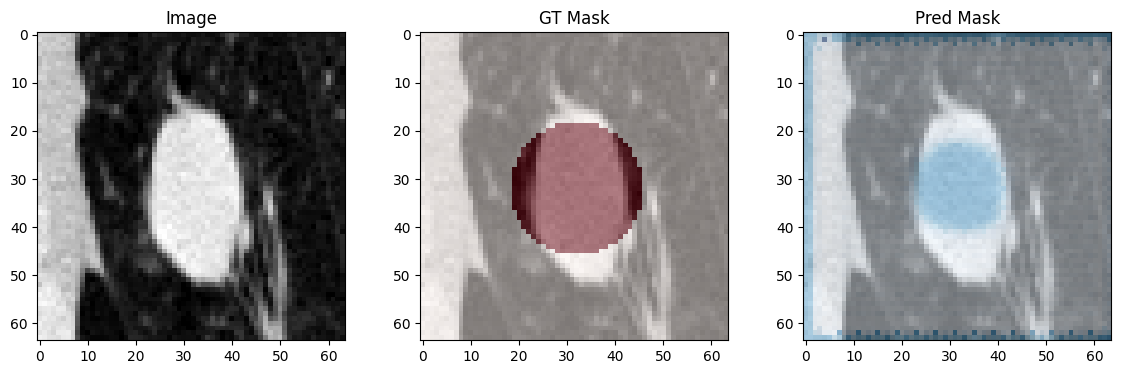

Saved NEW BEST model (val dice improved)


Epoch 7 val: 100%|██████████| 109/109 [00:04<00:00, 22.37it/s]


Epoch 7/60 | TrainLoss=0.5288 | ValDice=0.0258 | time=25.5s | LR=0.0001


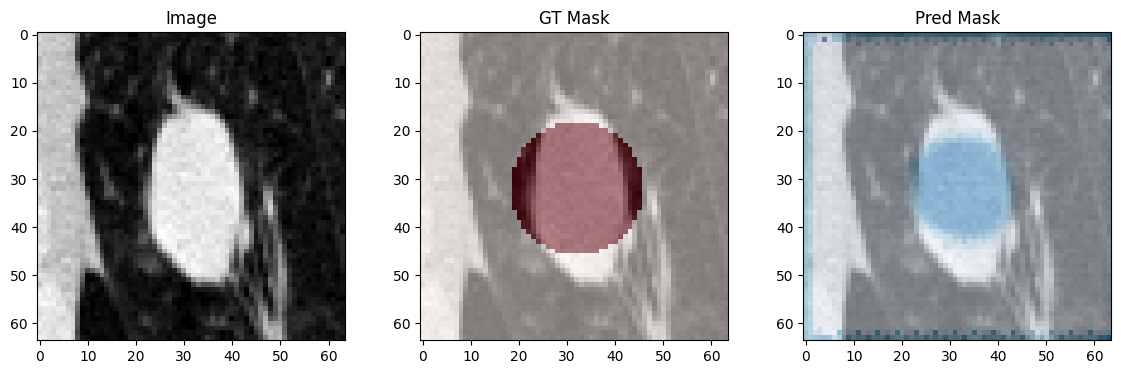

Saved NEW BEST model (val dice improved)


Epoch 8 val: 100%|██████████| 109/109 [00:04<00:00, 23.15it/s]


Epoch 8/60 | TrainLoss=0.5119 | ValDice=0.0356 | time=25.9s | LR=0.0001


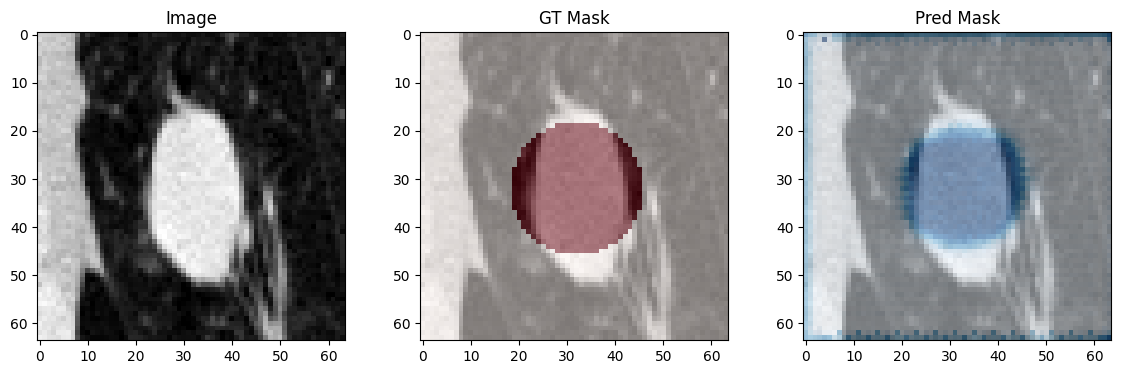

Saved NEW BEST model (val dice improved)


Epoch 9 val: 100%|██████████| 109/109 [00:04<00:00, 22.68it/s]


Epoch 9/60 | TrainLoss=0.4963 | ValDice=0.0476 | time=25.9s | LR=0.0001


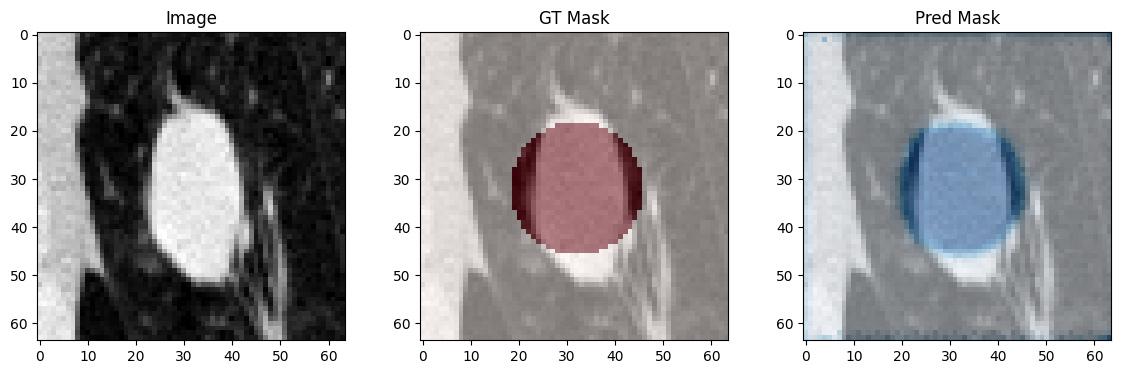

Saved NEW BEST model (val dice improved)


Epoch 10 val: 100%|██████████| 109/109 [00:04<00:00, 22.40it/s]


Epoch 10/60 | TrainLoss=0.4810 | ValDice=0.0665 | time=27.3s | LR=0.0001


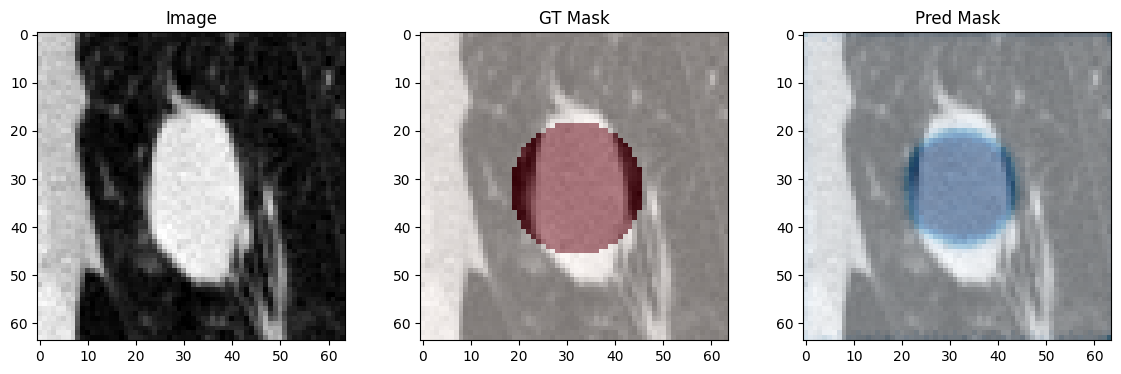

Saved NEW BEST model (val dice improved)


Epoch 11 val: 100%|██████████| 109/109 [00:04<00:00, 22.38it/s]


Epoch 11/60 | TrainLoss=0.4636 | ValDice=0.0962 | time=26.6s | LR=0.0001


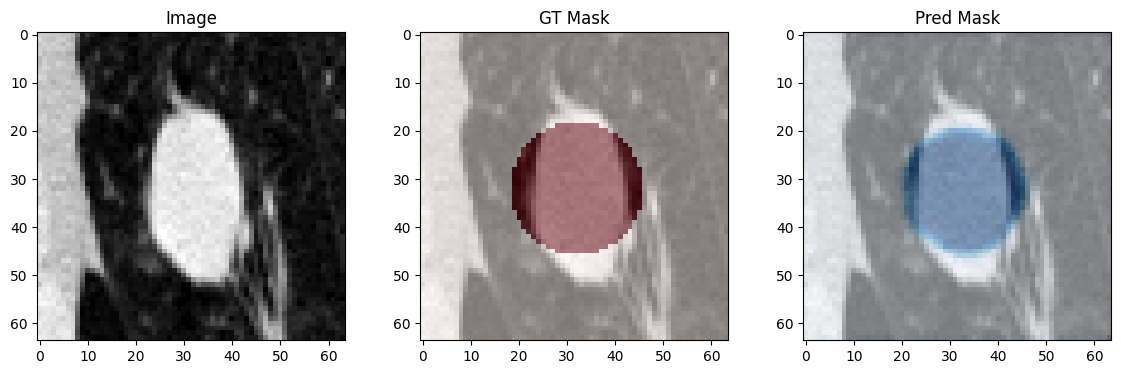

Saved NEW BEST model (val dice improved)


Epoch 12 val: 100%|██████████| 109/109 [00:05<00:00, 21.72it/s]


Epoch 12/60 | TrainLoss=0.4398 | ValDice=0.1503 | time=26.8s | LR=0.0001


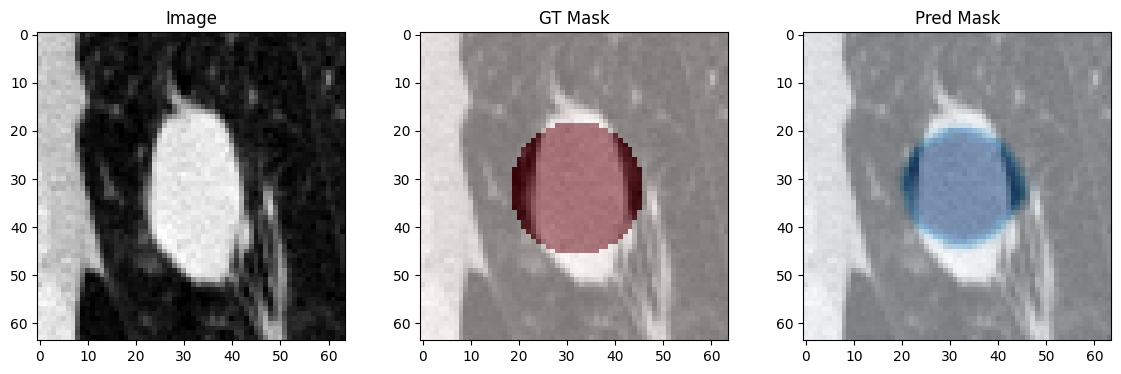

Saved NEW BEST model (val dice improved)


Epoch 13 val: 100%|██████████| 109/109 [00:05<00:00, 21.73it/s]


Epoch 13/60 | TrainLoss=0.4090 | ValDice=0.2191 | time=28.2s | LR=0.0001


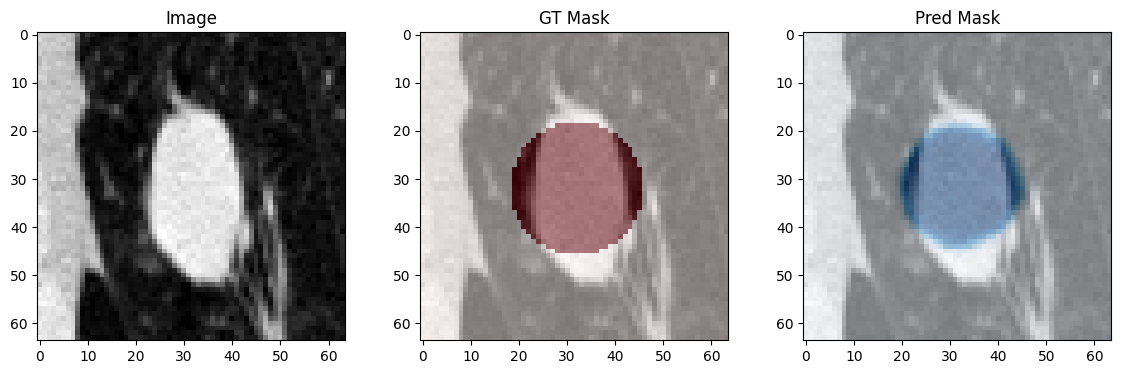

Saved NEW BEST model (val dice improved)


Epoch 14 val: 100%|██████████| 109/109 [00:05<00:00, 21.59it/s]


Epoch 14/60 | TrainLoss=0.3728 | ValDice=0.2907 | time=28.0s | LR=0.0001


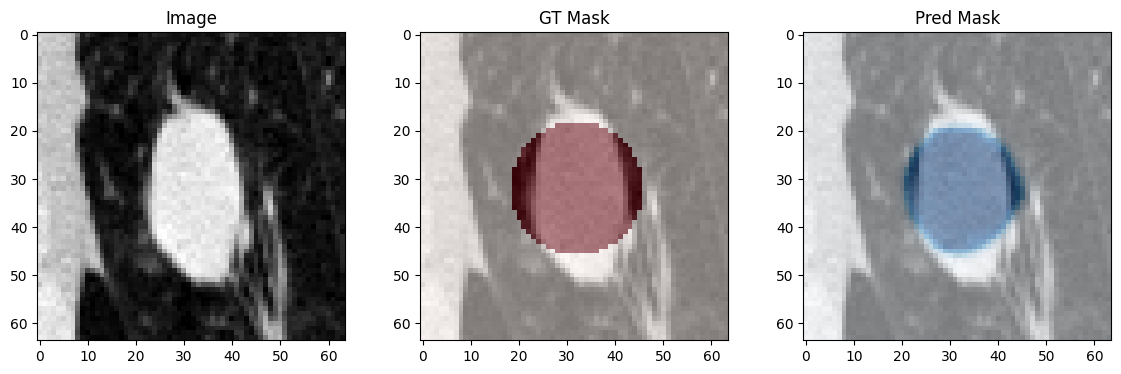

Saved NEW BEST model (val dice improved)


Epoch 15 val: 100%|██████████| 109/109 [00:05<00:00, 20.38it/s]


Epoch 15/60 | TrainLoss=0.3438 | ValDice=0.3385 | time=28.5s | LR=0.0001


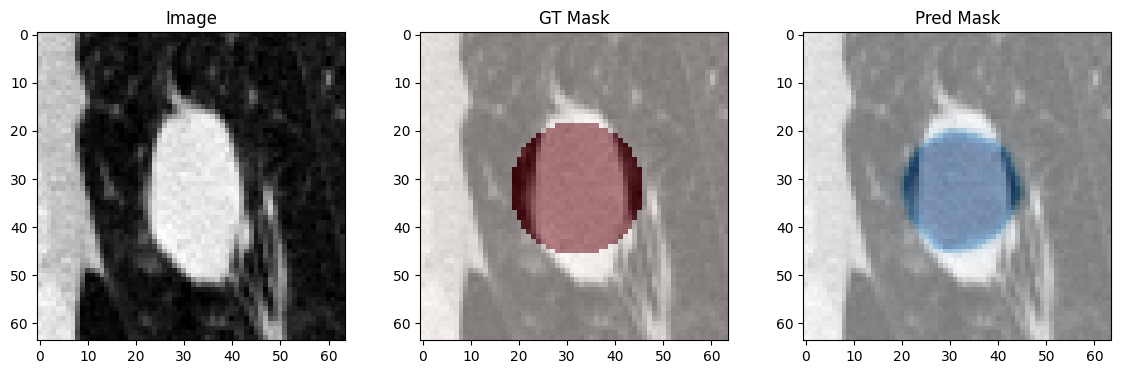

Saved NEW BEST model (val dice improved)


Epoch 16 val: 100%|██████████| 109/109 [00:05<00:00, 19.85it/s]


Epoch 16/60 | TrainLoss=0.3217 | ValDice=0.3721 | time=28.3s | LR=0.0001


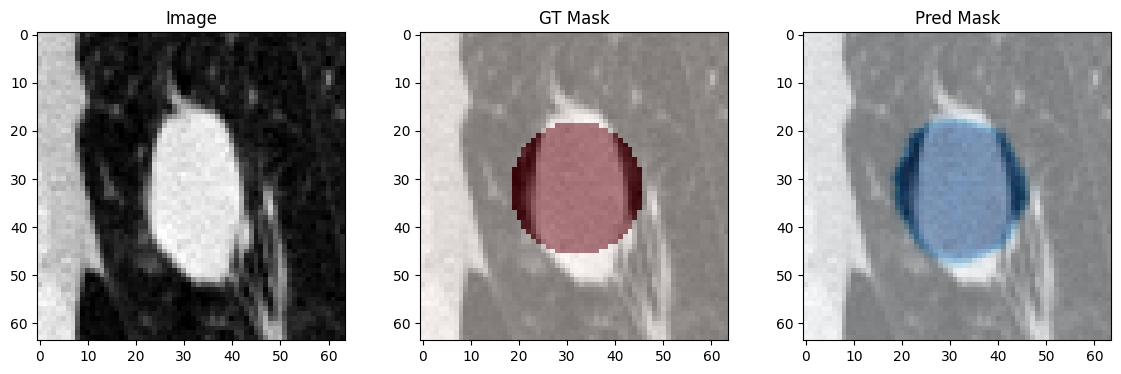

Saved NEW BEST model (val dice improved)


Epoch 17 val: 100%|██████████| 109/109 [00:04<00:00, 22.25it/s]


Epoch 17/60 | TrainLoss=0.3063 | ValDice=0.4025 | time=26.6s | LR=0.0001


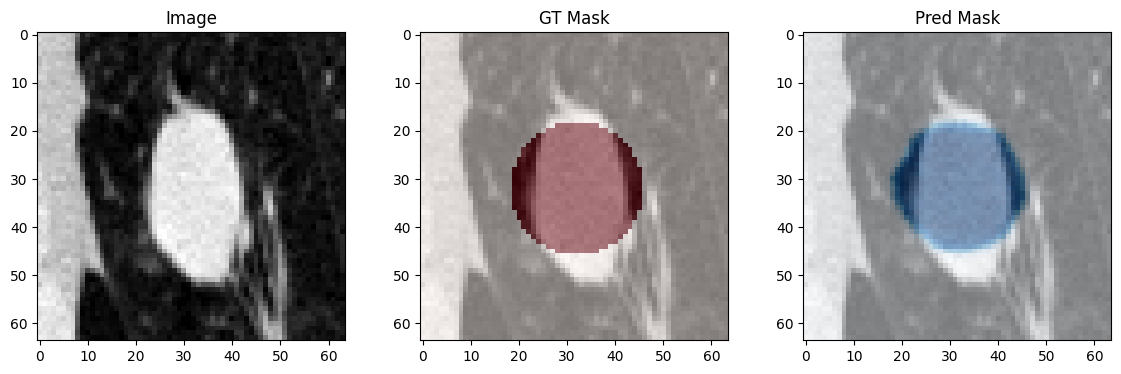

Saved NEW BEST model (val dice improved)


Epoch 18 val: 100%|██████████| 109/109 [00:04<00:00, 22.98it/s]


Epoch 18/60 | TrainLoss=0.2955 | ValDice=0.4211 | time=25.9s | LR=0.0001


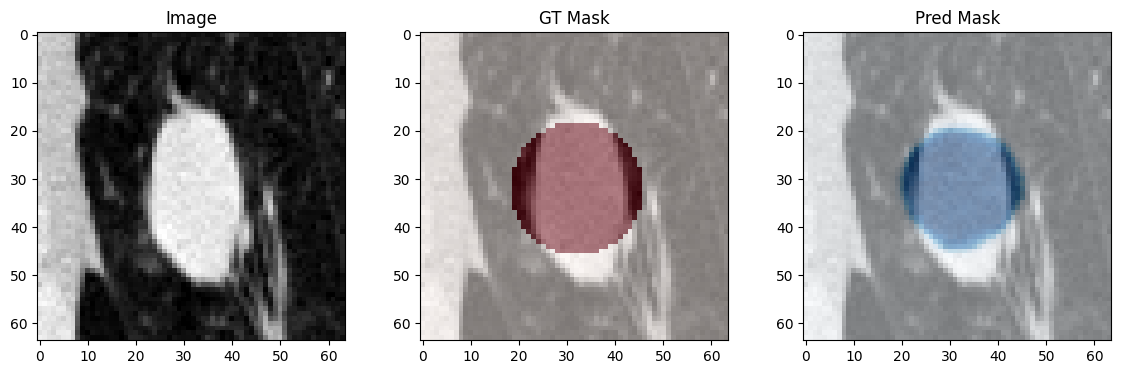

Saved NEW BEST model (val dice improved)


Epoch 19 val: 100%|██████████| 109/109 [00:04<00:00, 23.01it/s]


Epoch 19/60 | TrainLoss=0.2858 | ValDice=0.4326 | time=25.4s | LR=0.0001


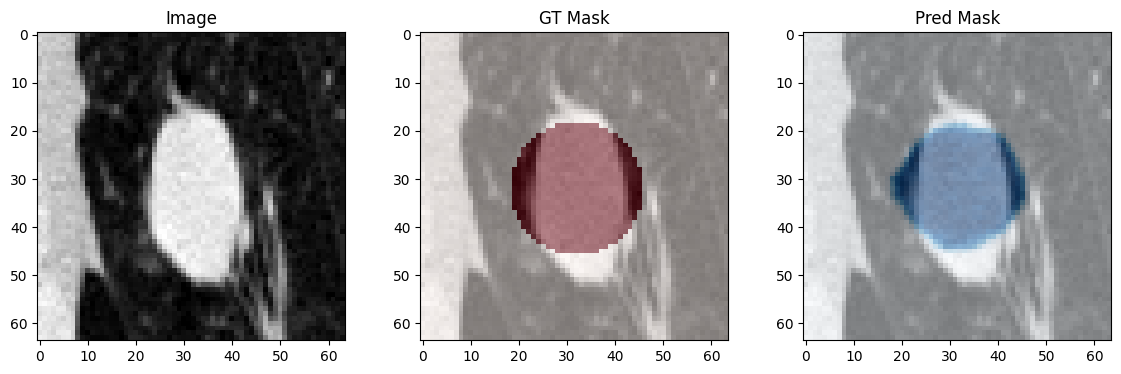

Saved NEW BEST model (val dice improved)


Epoch 20 val: 100%|██████████| 109/109 [00:05<00:00, 21.71it/s]


Epoch 20/60 | TrainLoss=0.2793 | ValDice=0.4527 | time=26.8s | LR=0.0001


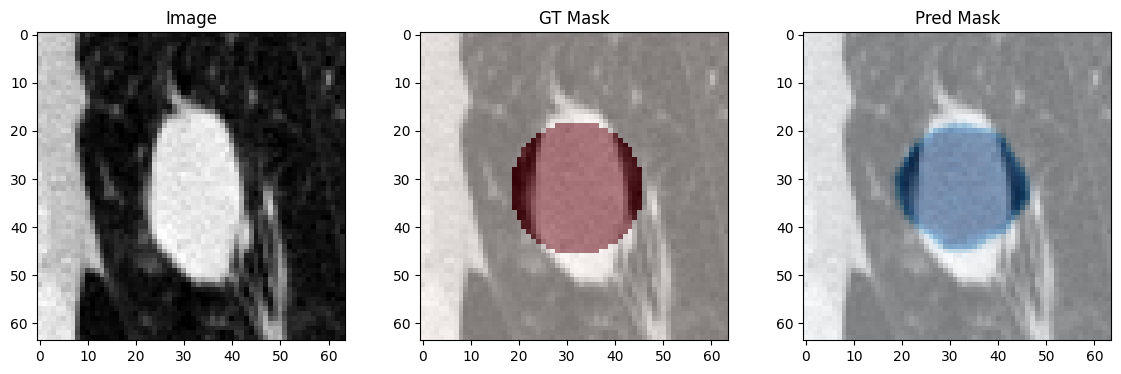

Saved NEW BEST model (val dice improved)


Epoch 21 val: 100%|██████████| 109/109 [00:04<00:00, 24.88it/s]


Epoch 21/60 | TrainLoss=0.2718 | ValDice=0.4665 | time=23.4s | LR=0.0001


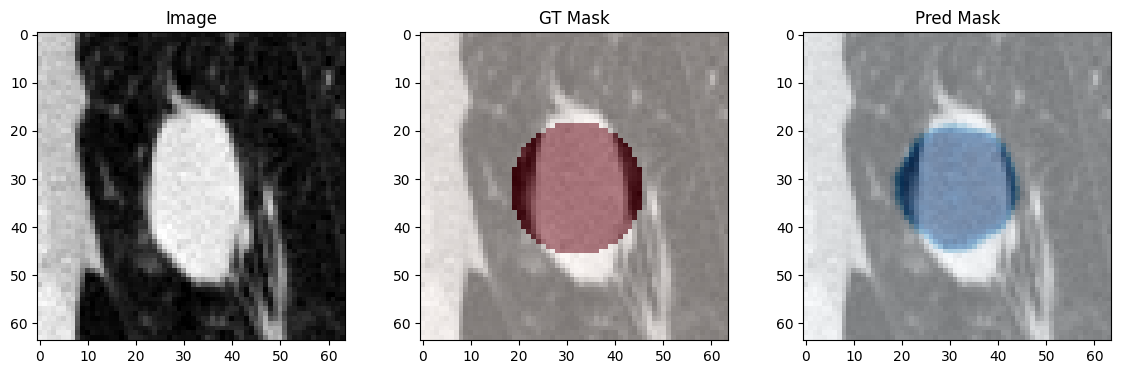

Saved NEW BEST model (val dice improved)


Epoch 22 val: 100%|██████████| 109/109 [00:04<00:00, 23.54it/s]


Epoch 22/60 | TrainLoss=0.2683 | ValDice=0.4793 | time=25.1s | LR=0.0001


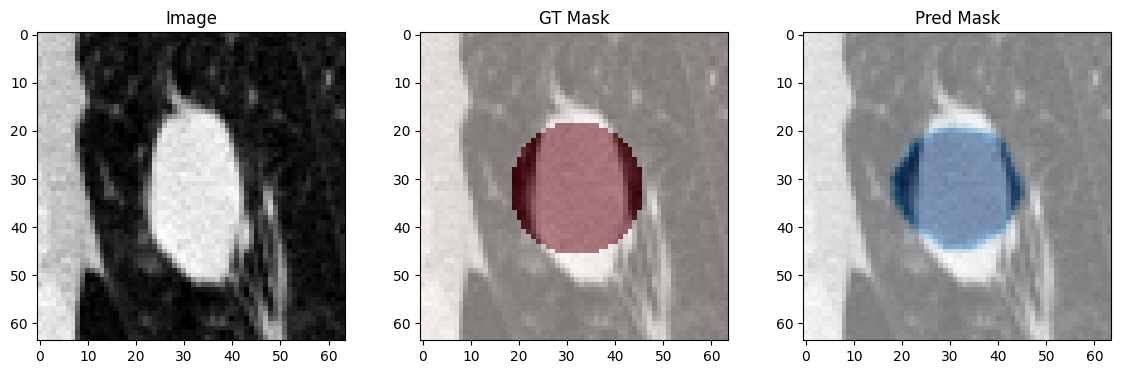

Saved NEW BEST model (val dice improved)


Epoch 23 val: 100%|██████████| 109/109 [00:04<00:00, 22.68it/s]


Epoch 23/60 | TrainLoss=0.2636 | ValDice=0.4784 | time=25.9s | LR=0.0001


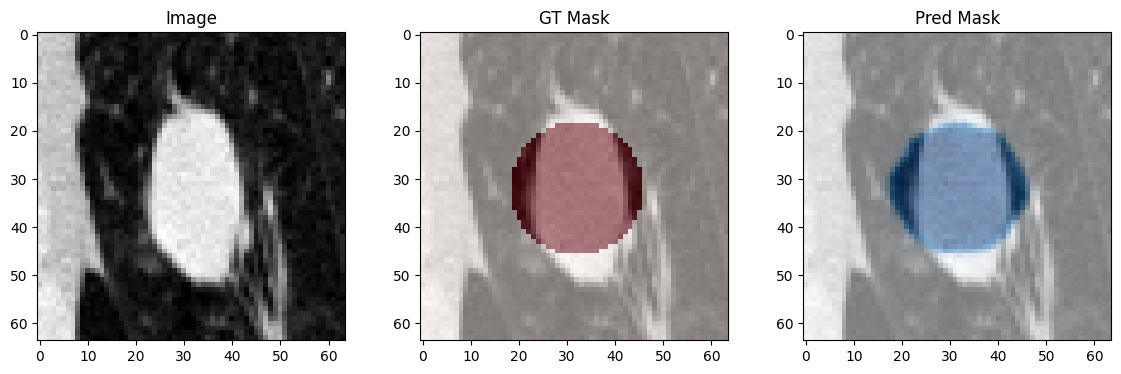

Epoch 24 val: 100%|██████████| 109/109 [00:04<00:00, 22.47it/s]


Epoch 24/60 | TrainLoss=0.2561 | ValDice=0.4847 | time=26.9s | LR=0.0001


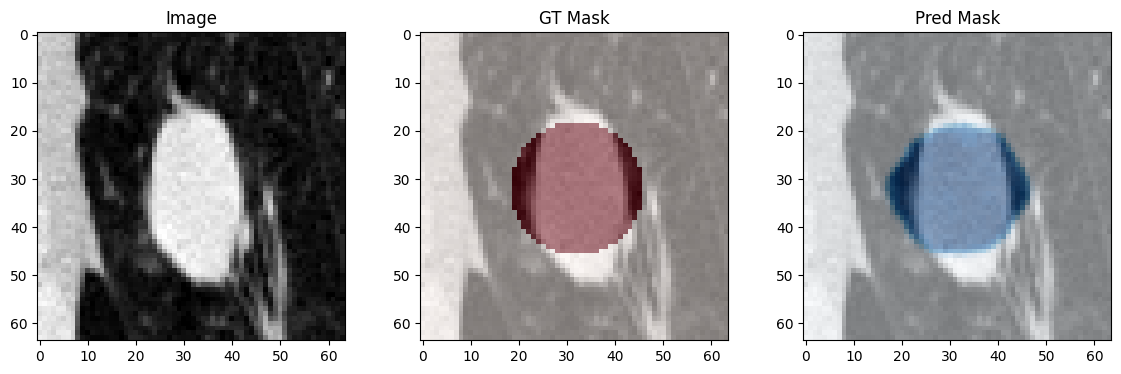

Saved NEW BEST model (val dice improved)


Epoch 25 val: 100%|██████████| 109/109 [00:05<00:00, 20.77it/s]


Epoch 25/60 | TrainLoss=0.2547 | ValDice=0.5012 | time=27.1s | LR=0.0001


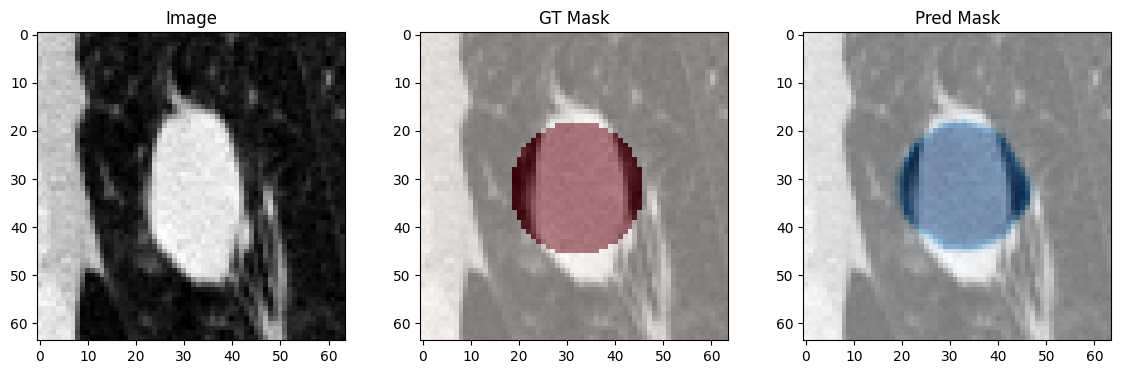

Saved NEW BEST model (val dice improved)


Epoch 26 val: 100%|██████████| 109/109 [00:04<00:00, 22.51it/s]


Epoch 26/60 | TrainLoss=0.2496 | ValDice=0.4861 | time=25.0s | LR=0.0001


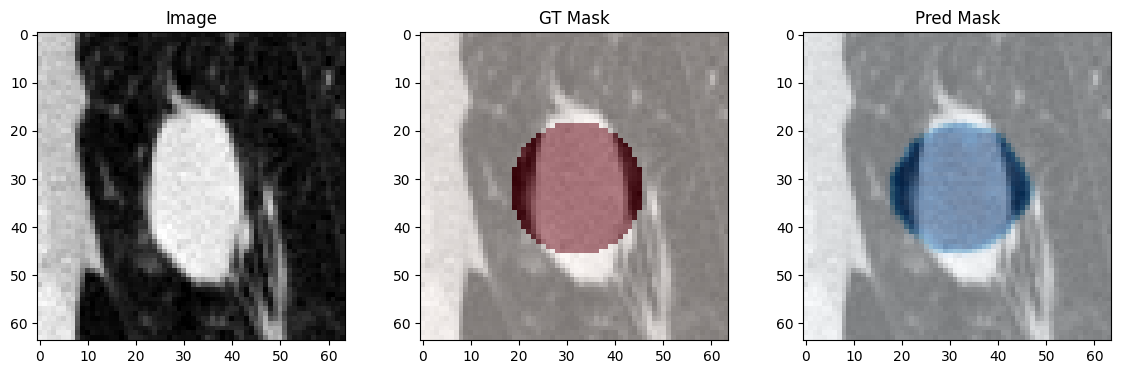

Epoch 27 val: 100%|██████████| 109/109 [00:05<00:00, 21.59it/s]


Epoch 27/60 | TrainLoss=0.2446 | ValDice=0.5141 | time=26.0s | LR=0.0001


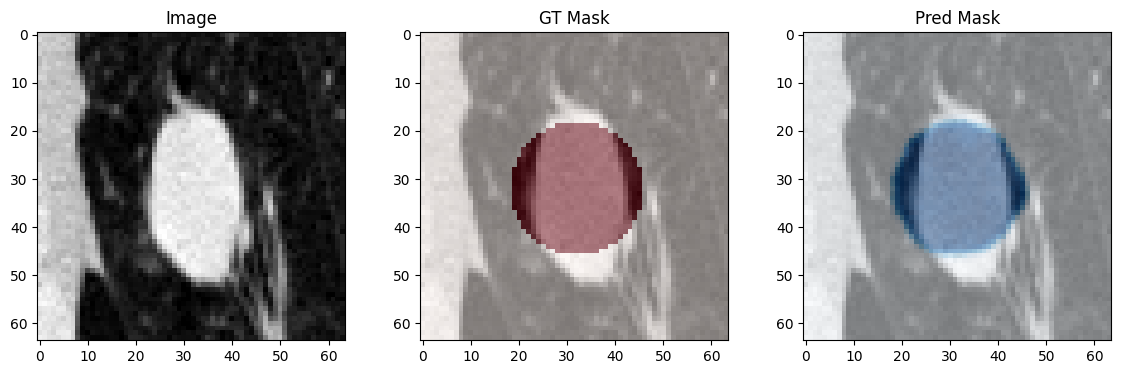

Saved NEW BEST model (val dice improved)


Epoch 28 val: 100%|██████████| 109/109 [00:04<00:00, 22.64it/s]


Epoch 28/60 | TrainLoss=0.2399 | ValDice=0.5186 | time=25.7s | LR=0.0001


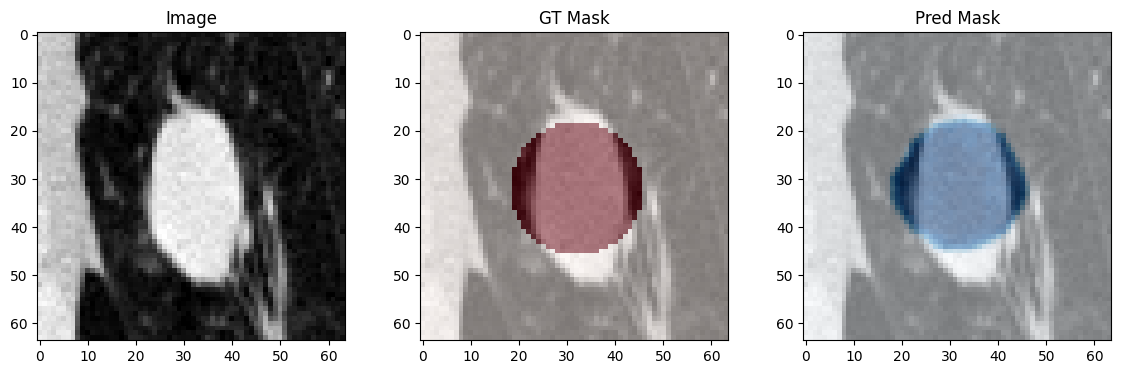

Saved NEW BEST model (val dice improved)


Epoch 29 val: 100%|██████████| 109/109 [00:05<00:00, 20.07it/s]


Epoch 29/60 | TrainLoss=0.2362 | ValDice=0.5328 | time=26.1s | LR=0.0001


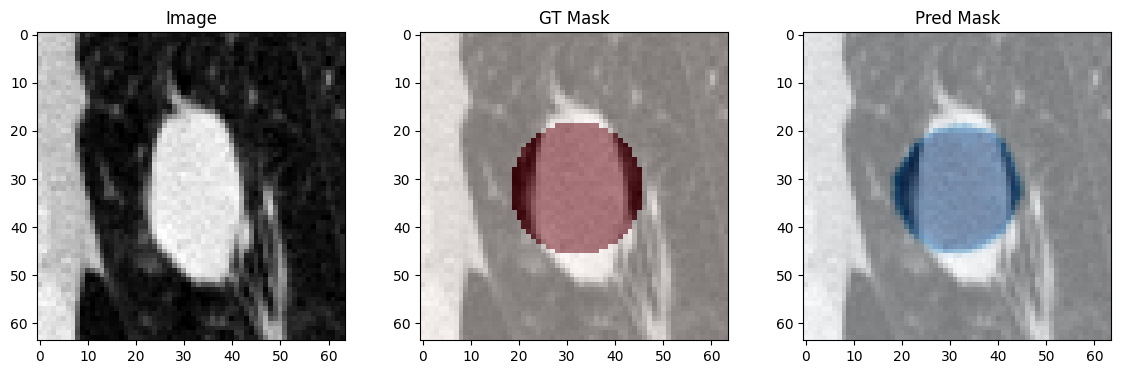

Saved NEW BEST model (val dice improved)


Epoch 30 val: 100%|██████████| 109/109 [00:05<00:00, 20.25it/s]


Epoch 30/60 | TrainLoss=0.2356 | ValDice=0.5335 | time=26.0s | LR=0.0001


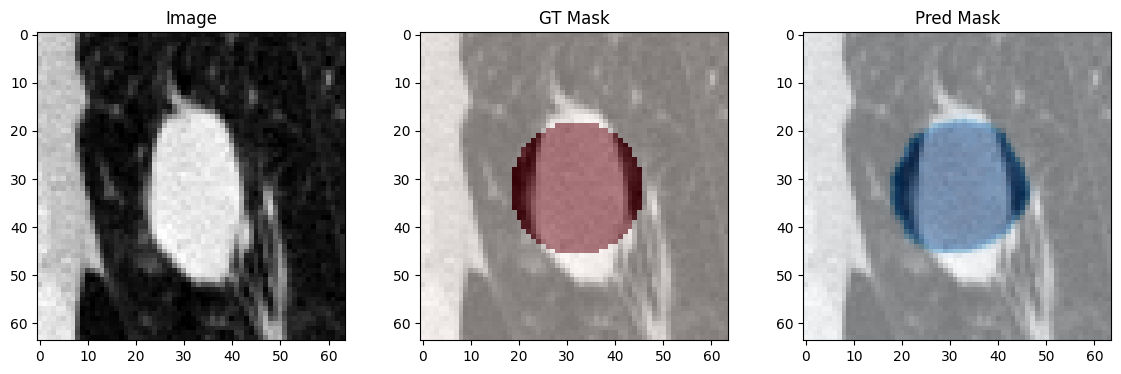

Saved NEW BEST model (val dice improved)


Epoch 31 val: 100%|██████████| 109/109 [00:04<00:00, 24.08it/s]


Epoch 31/60 | TrainLoss=0.2309 | ValDice=0.5304 | time=26.1s | LR=0.0001


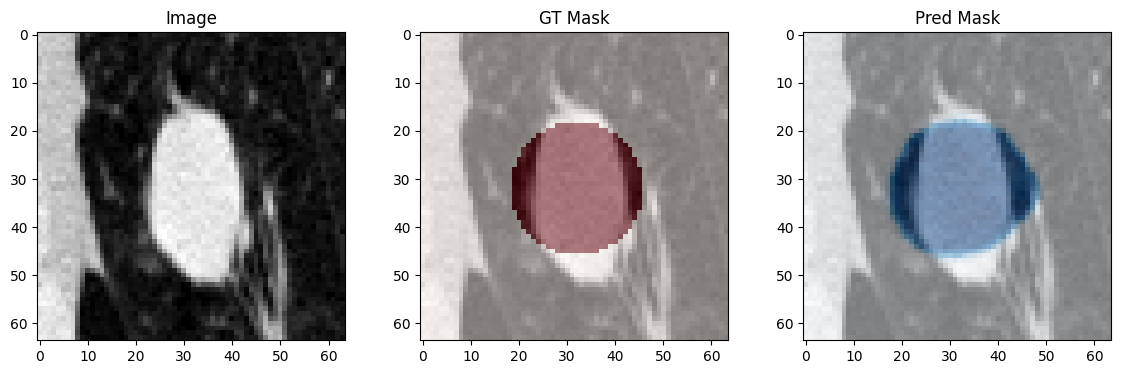

Epoch 32 val: 100%|██████████| 109/109 [00:04<00:00, 22.91it/s]


Epoch 32/60 | TrainLoss=0.2280 | ValDice=0.5608 | time=25.6s | LR=0.0001


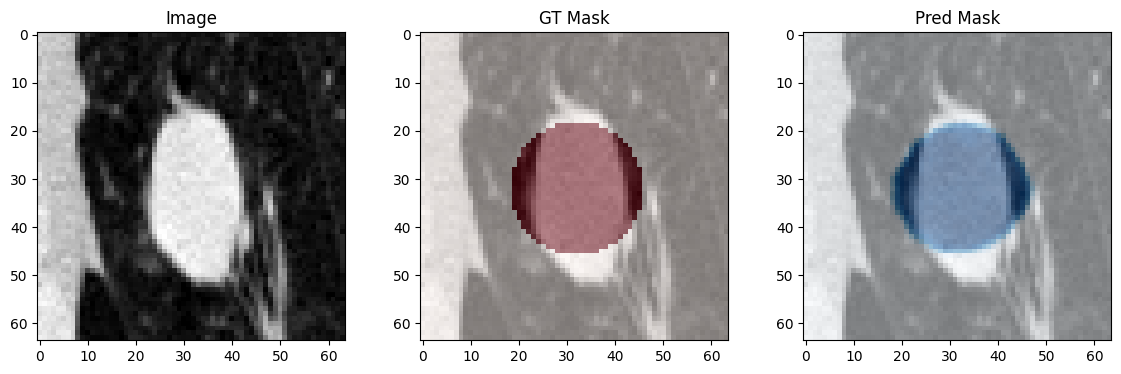

Saved NEW BEST model (val dice improved)


Epoch 33 val: 100%|██████████| 109/109 [00:04<00:00, 22.43it/s]


Epoch 33/60 | TrainLoss=0.2233 | ValDice=0.5597 | time=25.8s | LR=0.0001


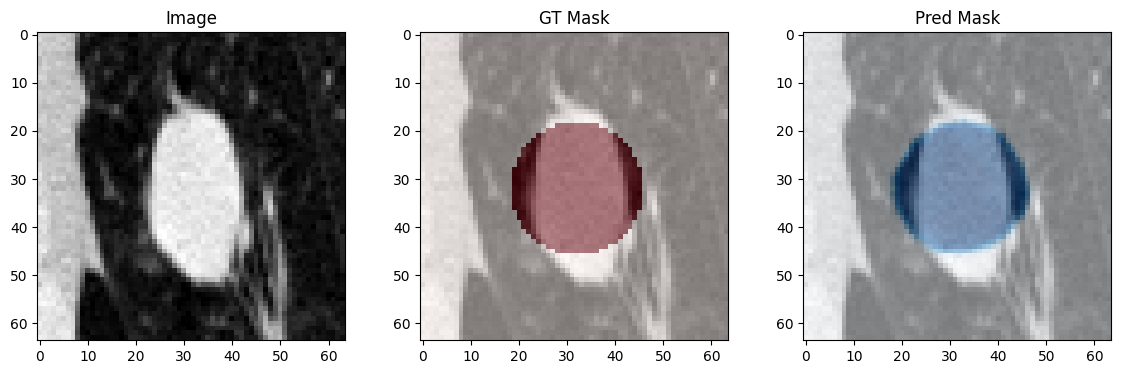

Epoch 34 val: 100%|██████████| 109/109 [00:04<00:00, 22.22it/s]


Epoch 34/60 | TrainLoss=0.2196 | ValDice=0.5675 | time=25.6s | LR=0.0001


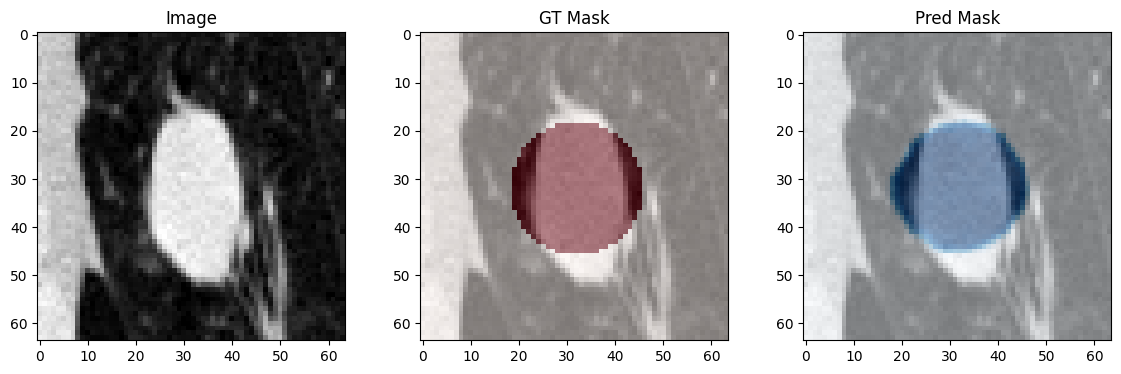

Saved NEW BEST model (val dice improved)


Epoch 35 val: 100%|██████████| 109/109 [00:04<00:00, 22.57it/s]


Epoch 35/60 | TrainLoss=0.2179 | ValDice=0.5678 | time=25.6s | LR=0.0001


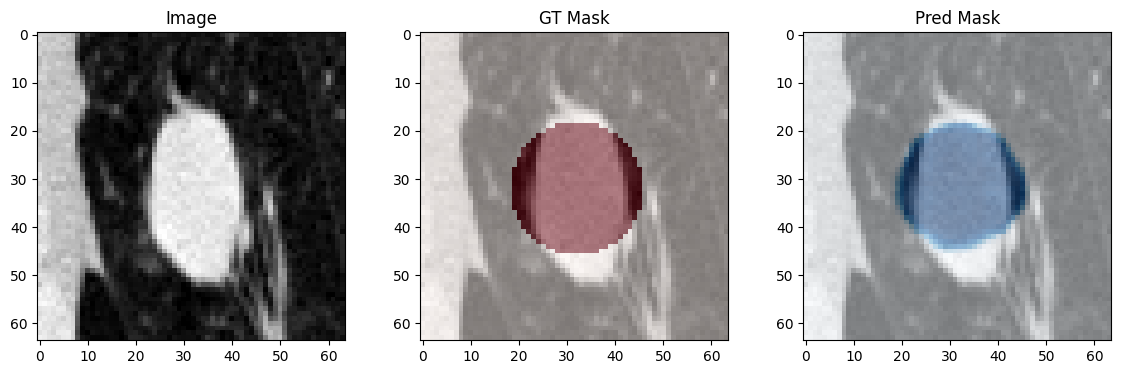

Saved NEW BEST model (val dice improved)


Epoch 36 val: 100%|██████████| 109/109 [00:04<00:00, 23.82it/s]


Epoch 36/60 | TrainLoss=0.2141 | ValDice=0.5816 | time=25.2s | LR=0.0001


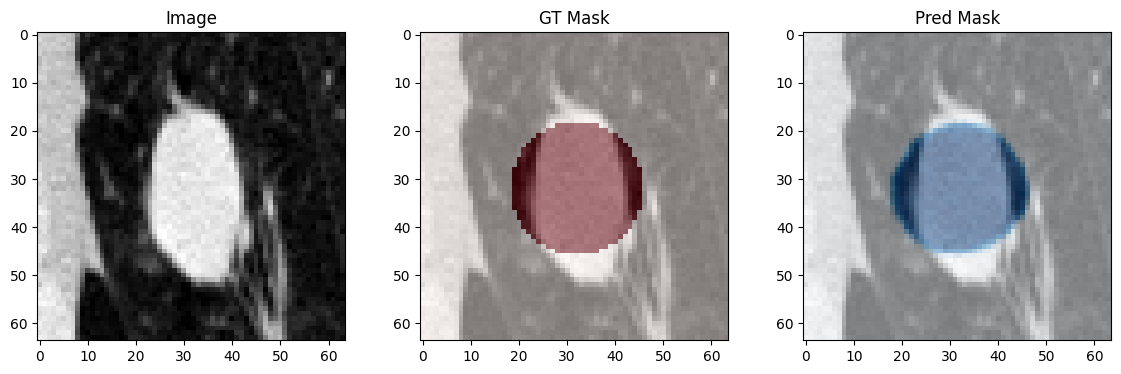

Saved NEW BEST model (val dice improved)


Epoch 37 val: 100%|██████████| 109/109 [00:05<00:00, 21.44it/s]


Epoch 37/60 | TrainLoss=0.2108 | ValDice=0.5707 | time=25.8s | LR=0.0001


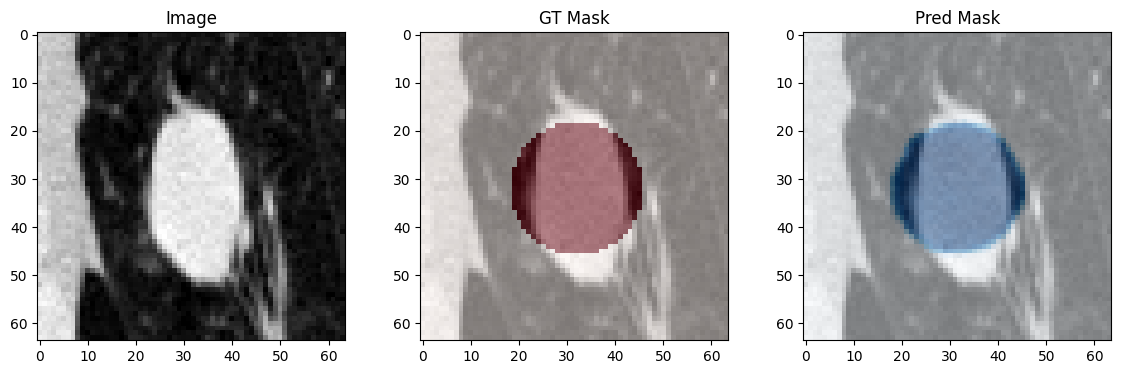

Epoch 38 val: 100%|██████████| 109/109 [00:04<00:00, 22.58it/s]


Epoch 38/60 | TrainLoss=0.2068 | ValDice=0.5937 | time=26.4s | LR=0.0001


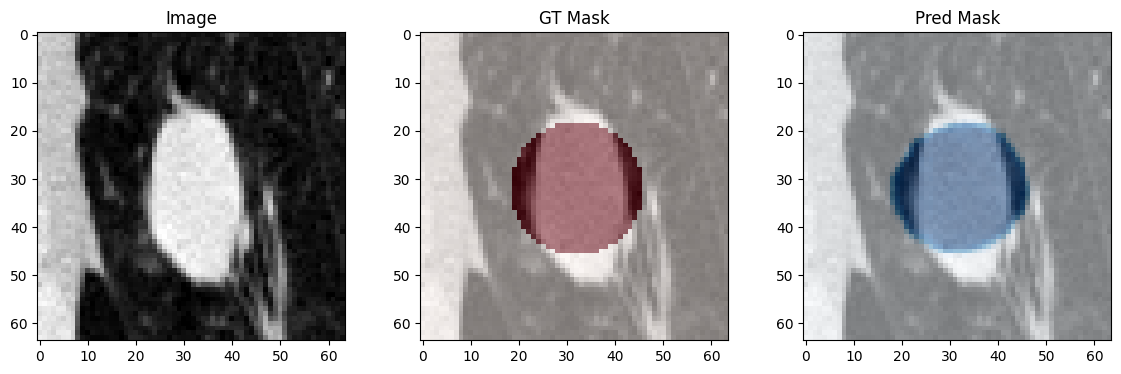

Saved NEW BEST model (val dice improved)


Epoch 39 val: 100%|██████████| 109/109 [00:04<00:00, 22.58it/s]


Epoch 39/60 | TrainLoss=0.2045 | ValDice=0.5897 | time=25.6s | LR=0.0001


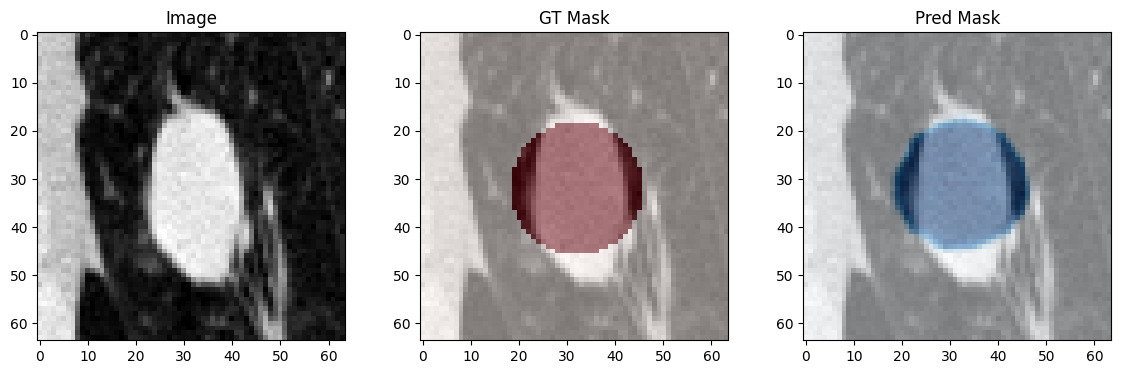

Epoch 40 val: 100%|██████████| 109/109 [00:04<00:00, 23.72it/s]


Epoch 40/60 | TrainLoss=0.2011 | ValDice=0.6061 | time=25.5s | LR=0.0001


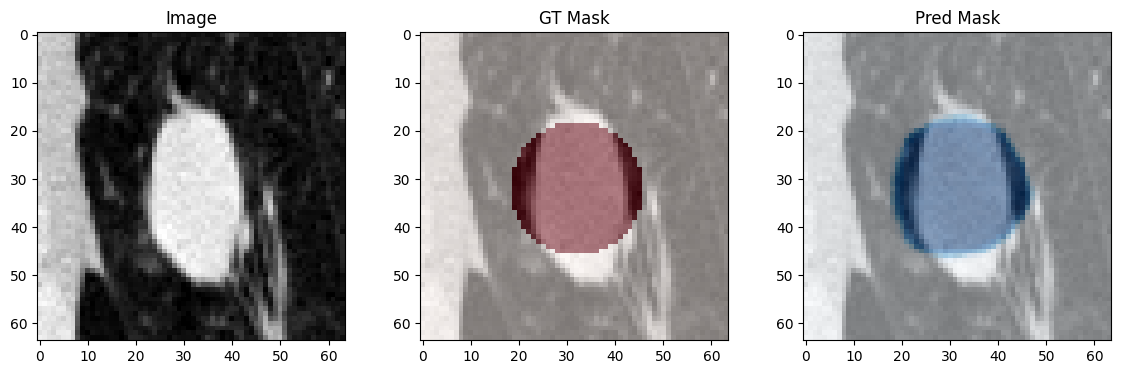

Saved NEW BEST model (val dice improved)


Epoch 41 val: 100%|██████████| 109/109 [00:04<00:00, 21.90it/s]


Epoch 41/60 | TrainLoss=0.1988 | ValDice=0.6078 | time=26.1s | LR=0.0001


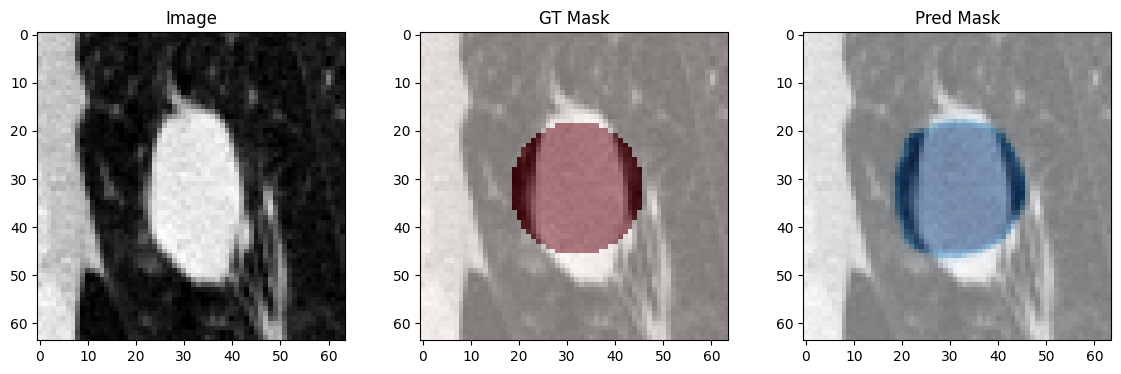

Saved NEW BEST model (val dice improved)


Epoch 42 val: 100%|██████████| 109/109 [00:04<00:00, 22.78it/s]


Epoch 42/60 | TrainLoss=0.1966 | ValDice=0.6096 | time=25.9s | LR=0.0001


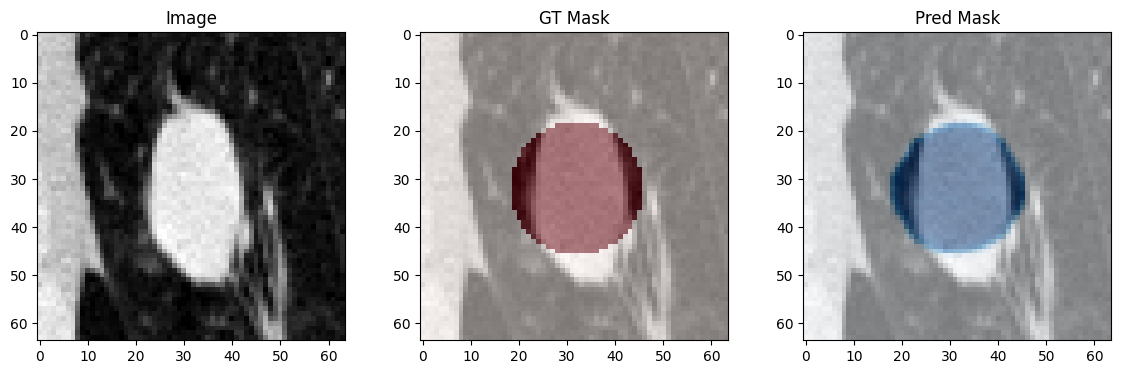

Saved NEW BEST model (val dice improved)


Epoch 43 val: 100%|██████████| 109/109 [00:05<00:00, 21.39it/s]


Epoch 43/60 | TrainLoss=0.1921 | ValDice=0.6247 | time=25.6s | LR=0.0001


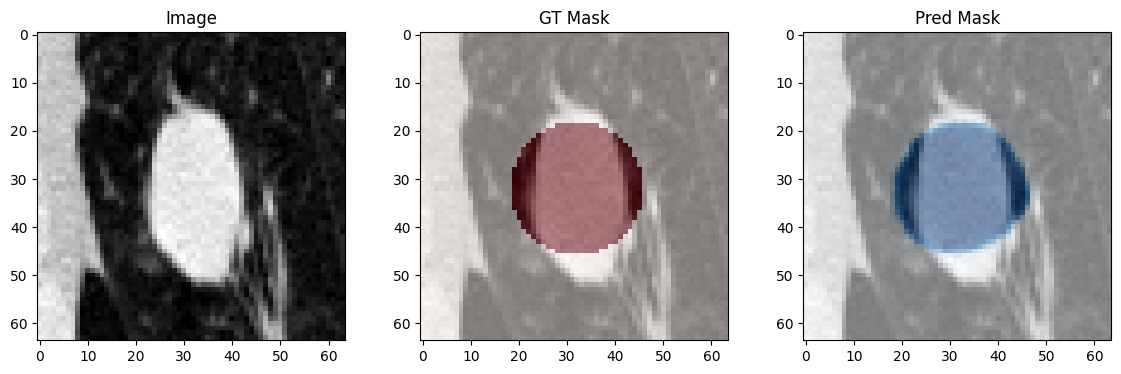

Saved NEW BEST model (val dice improved)


Epoch 44 val: 100%|██████████| 109/109 [00:05<00:00, 21.58it/s]


Epoch 44/60 | TrainLoss=0.1904 | ValDice=0.6104 | time=25.6s | LR=0.0001


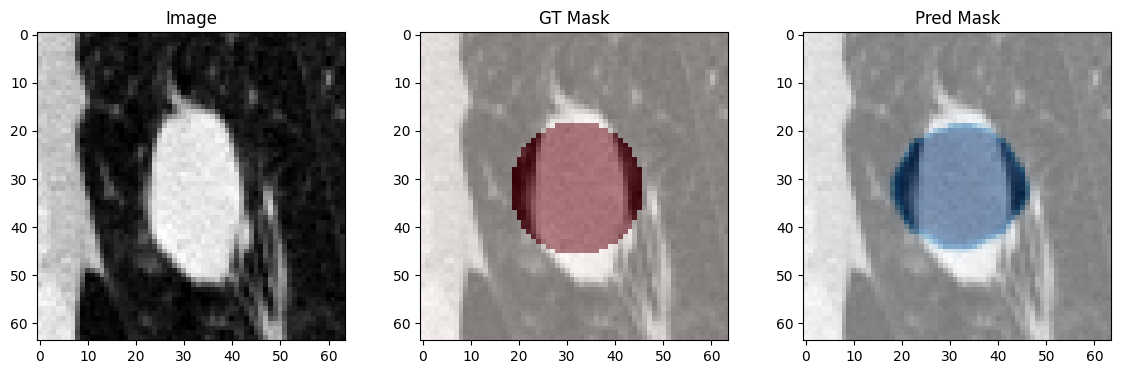

Epoch 45 val: 100%|██████████| 109/109 [00:05<00:00, 21.58it/s]


Epoch 45/60 | TrainLoss=0.1854 | ValDice=0.6107 | time=26.2s | LR=0.0001


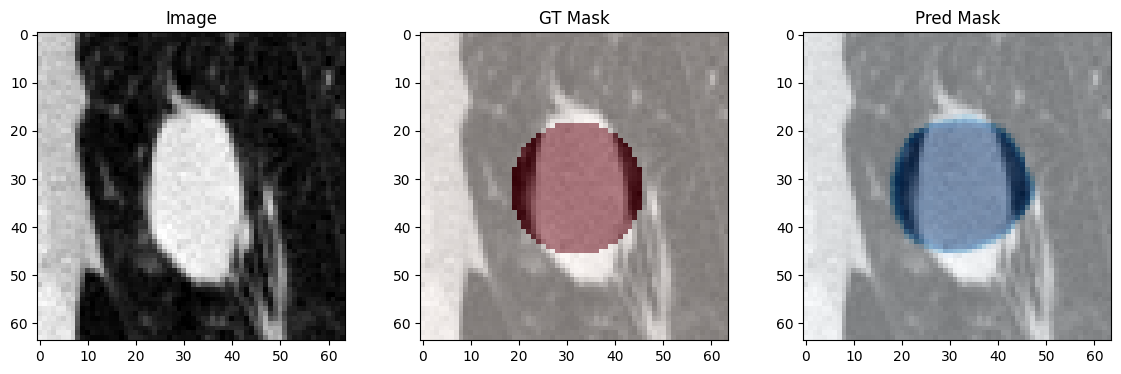

Epoch 46 val: 100%|██████████| 109/109 [00:04<00:00, 22.61it/s]


Epoch 46/60 | TrainLoss=0.1803 | ValDice=0.6329 | time=26.4s | LR=0.0001


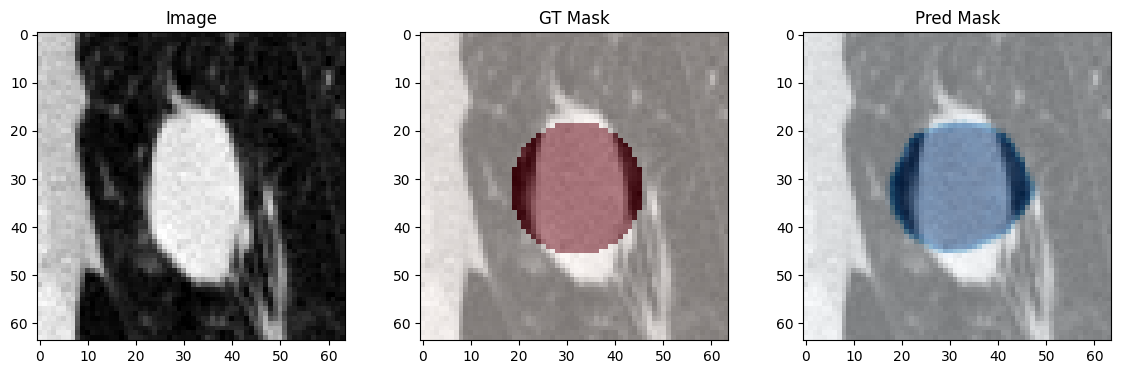

Saved NEW BEST model (val dice improved)


Epoch 47 val: 100%|██████████| 109/109 [00:05<00:00, 21.06it/s]


Epoch 47/60 | TrainLoss=0.1802 | ValDice=0.6278 | time=25.9s | LR=0.0001


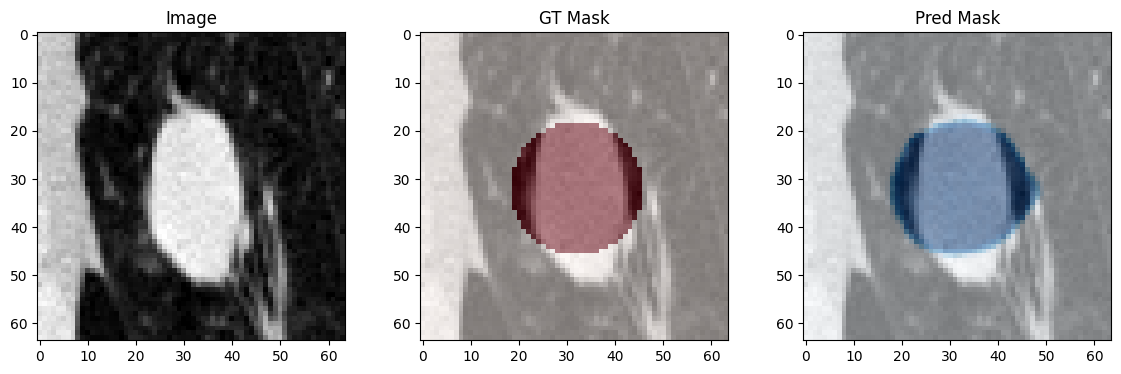

Epoch 48 val: 100%|██████████| 109/109 [00:04<00:00, 22.21it/s]


Epoch 48/60 | TrainLoss=0.1769 | ValDice=0.6380 | time=26.6s | LR=0.0001


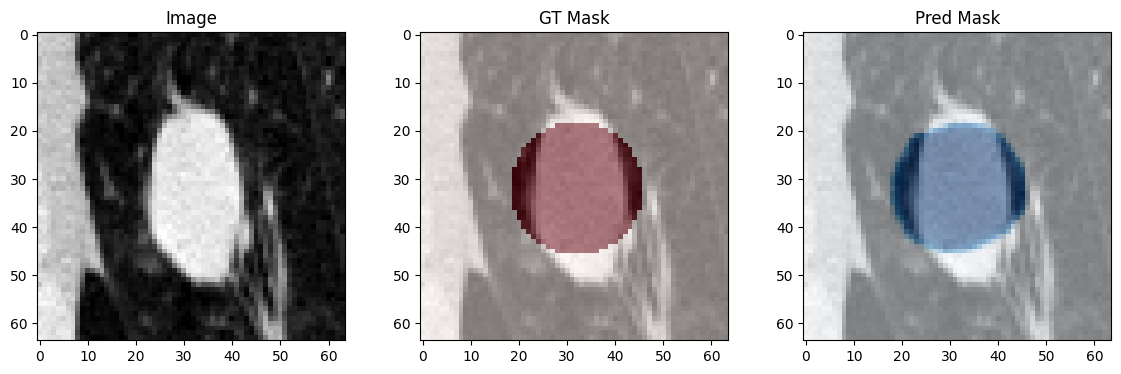

Saved NEW BEST model (val dice improved)


Epoch 49 val: 100%|██████████| 109/109 [00:04<00:00, 22.39it/s]


Epoch 49/60 | TrainLoss=0.1737 | ValDice=0.6380 | time=25.1s | LR=0.0001


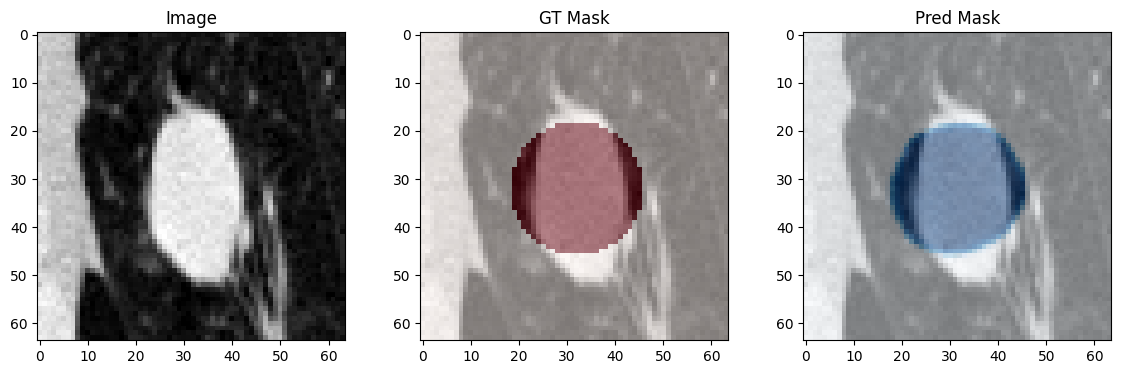

Epoch 50 val: 100%|██████████| 109/109 [00:04<00:00, 22.94it/s]


Epoch 50/60 | TrainLoss=0.1730 | ValDice=0.6403 | time=25.1s | LR=0.0001


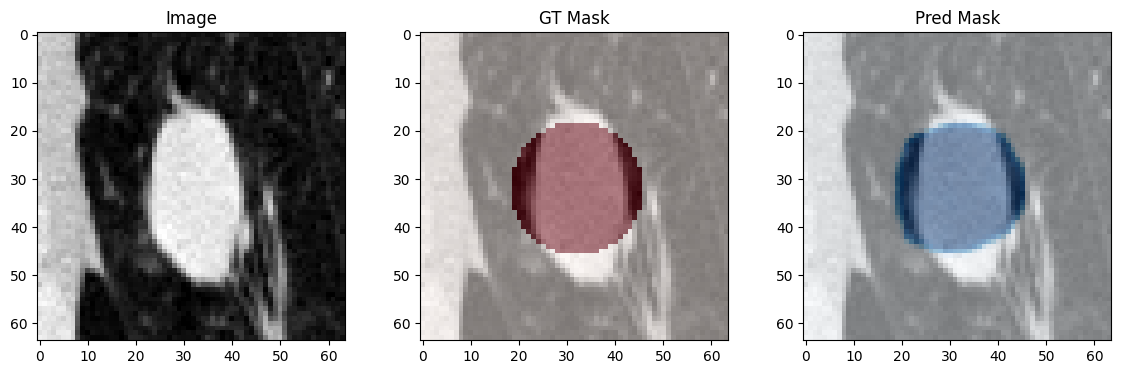

Saved NEW BEST model (val dice improved)


Epoch 51 val: 100%|██████████| 109/109 [00:04<00:00, 23.63it/s]


Epoch 51/60 | TrainLoss=0.1689 | ValDice=0.6537 | time=25.6s | LR=0.0001


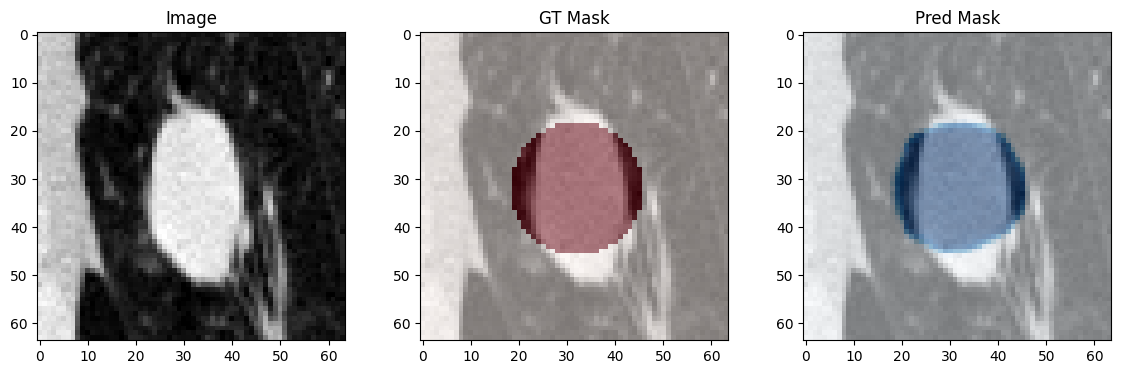

Saved NEW BEST model (val dice improved)


Epoch 52 val: 100%|██████████| 109/109 [00:04<00:00, 23.17it/s]


Epoch 52/60 | TrainLoss=0.1690 | ValDice=0.6414 | time=25.5s | LR=0.0001


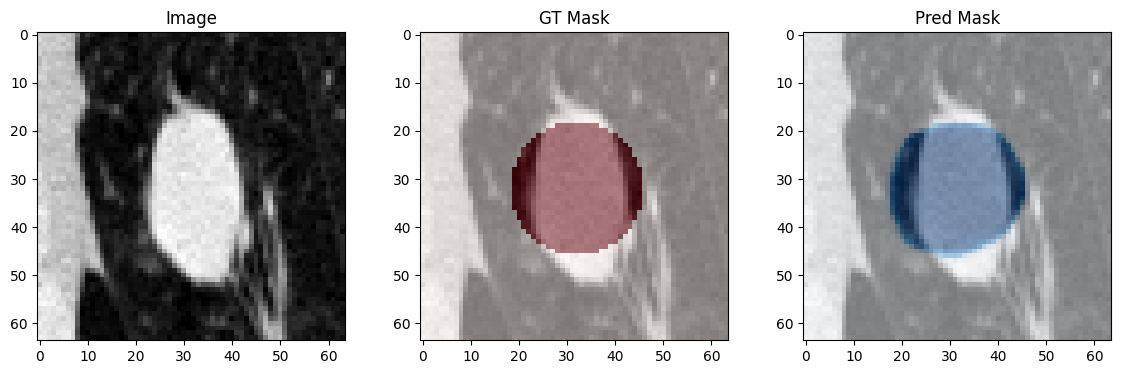

Epoch 53 val: 100%|██████████| 109/109 [00:04<00:00, 23.04it/s]


Epoch 53/60 | TrainLoss=0.1657 | ValDice=0.6483 | time=25.8s | LR=0.0001


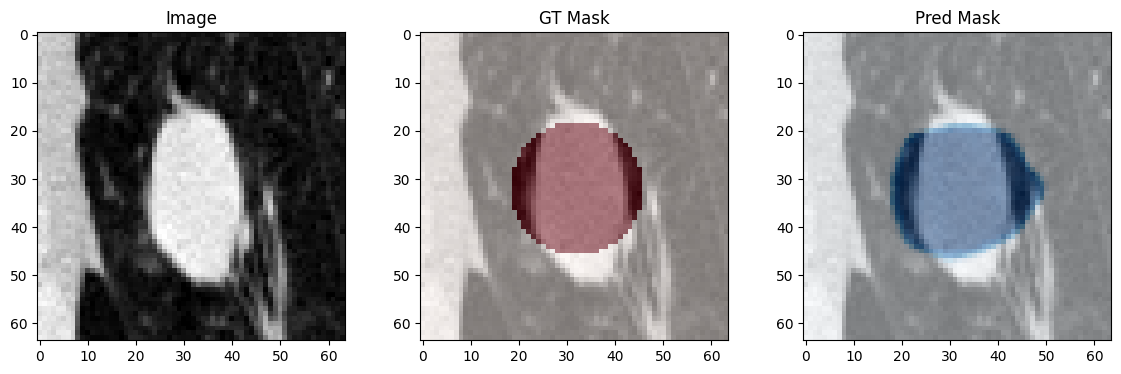

Epoch 54 val: 100%|██████████| 109/109 [00:04<00:00, 23.01it/s]


Epoch 54/60 | TrainLoss=0.1635 | ValDice=0.6551 | time=26.2s | LR=0.0001


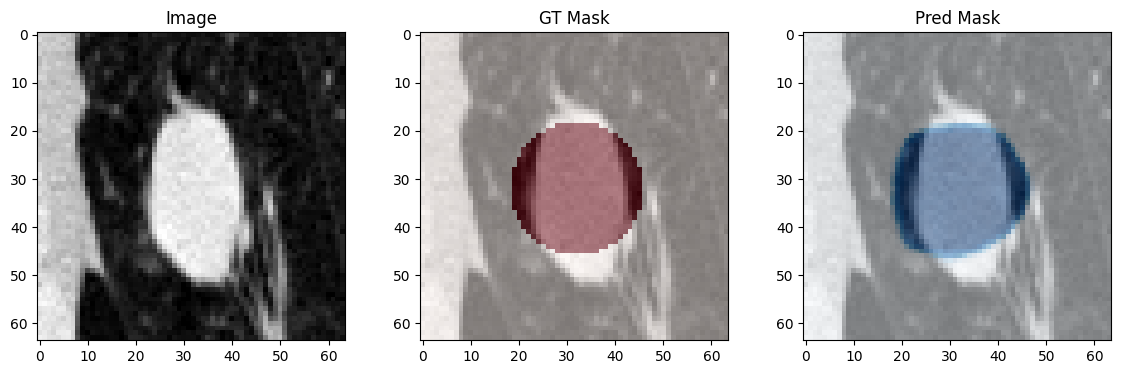

Saved NEW BEST model (val dice improved)


Epoch 55 val: 100%|██████████| 109/109 [00:04<00:00, 23.57it/s]


Epoch 55/60 | TrainLoss=0.1615 | ValDice=0.6539 | time=25.8s | LR=0.0001


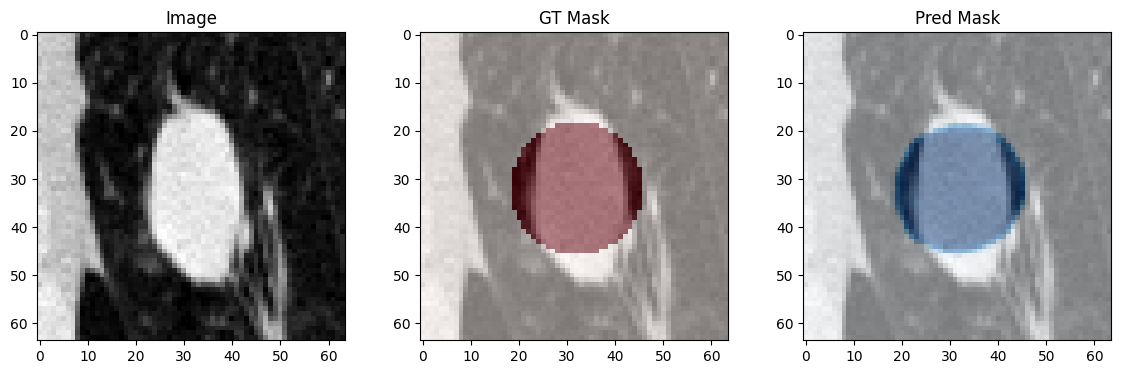

Epoch 56 val: 100%|██████████| 109/109 [00:05<00:00, 21.60it/s]


Epoch 56/60 | TrainLoss=0.1587 | ValDice=0.6387 | time=25.7s | LR=0.0001


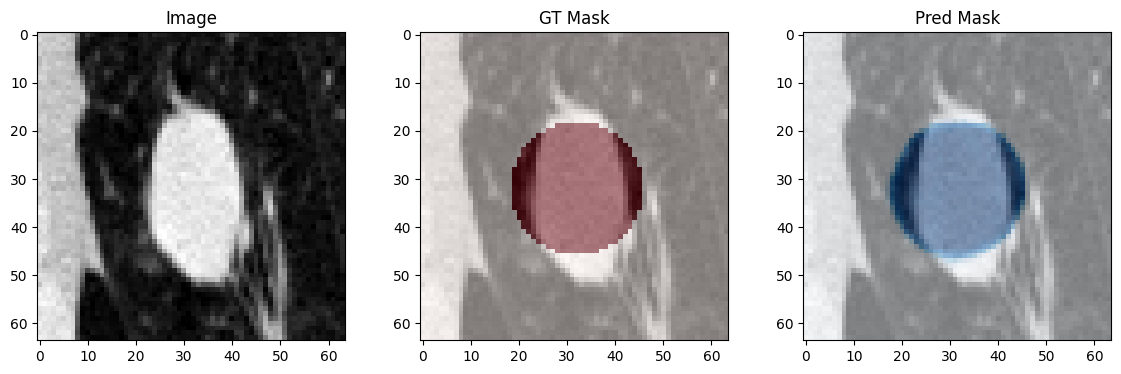

Epoch 57 val: 100%|██████████| 109/109 [00:05<00:00, 21.15it/s]


Epoch 57/60 | TrainLoss=0.1554 | ValDice=0.6688 | time=26.1s | LR=0.0001


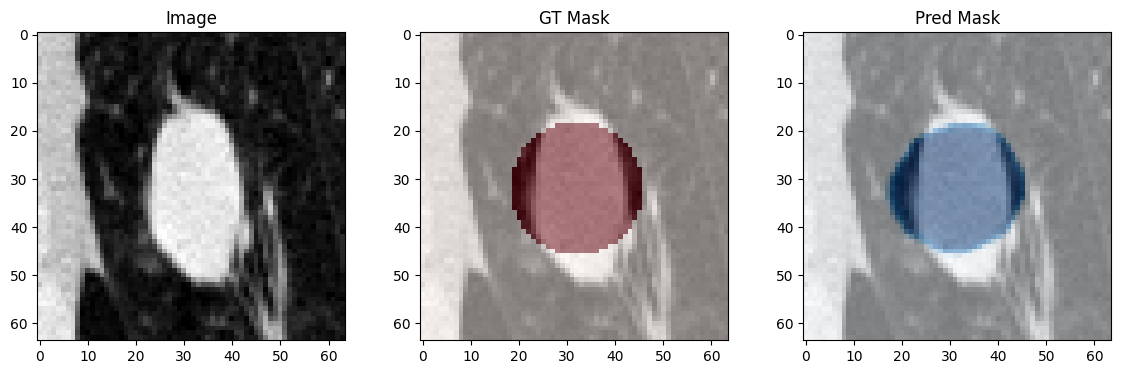

Saved NEW BEST model (val dice improved)


Epoch 58 val: 100%|██████████| 109/109 [00:05<00:00, 21.18it/s]


Epoch 58/60 | TrainLoss=0.1534 | ValDice=0.6391 | time=26.7s | LR=0.0001


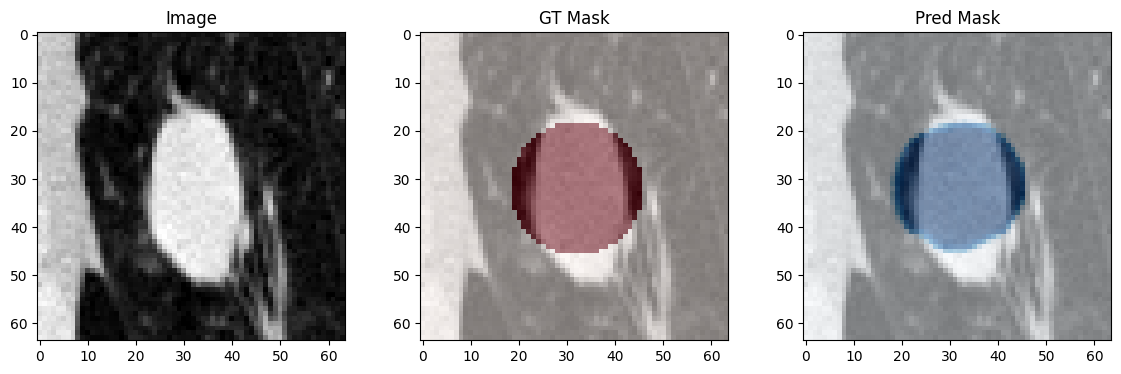

Epoch 59 val: 100%|██████████| 109/109 [00:04<00:00, 22.07it/s]


Epoch 59/60 | TrainLoss=0.1518 | ValDice=0.6734 | time=25.9s | LR=0.0001


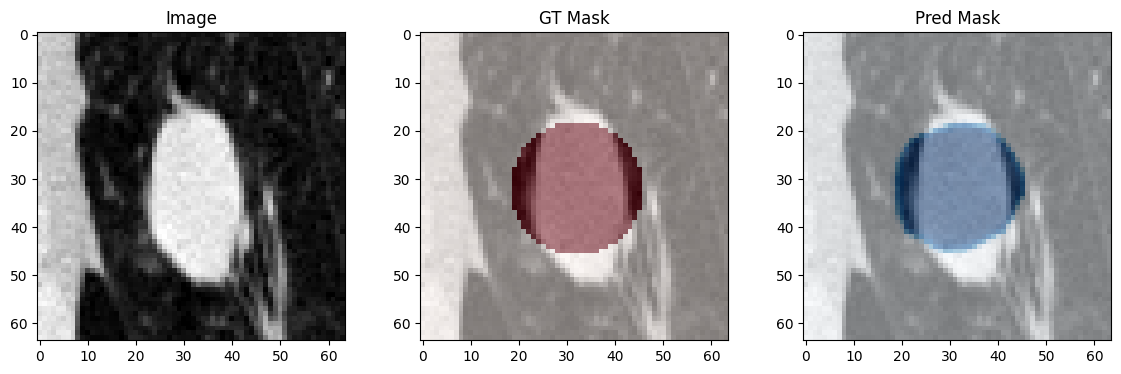

Saved NEW BEST model (val dice improved)


Epoch 60 val: 100%|██████████| 109/109 [00:04<00:00, 22.66it/s]


Epoch 60/60 | TrainLoss=0.1496 | ValDice=0.6763 | time=26.1s | LR=0.0001


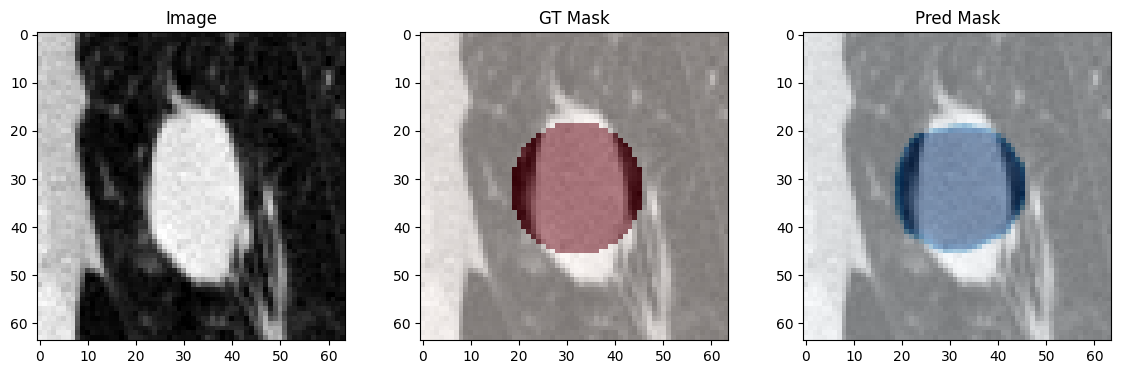

Saved NEW BEST model (val dice improved)

Training complete. Best Val Dice: 0.6763147711753845


In [12]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(device.type == "cuda"))

import csv

history = []  # to store metrics each epoch
best_val = 0.0
patience = 8
no_improve = 0
EPOCHS = 60

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    unet.train()

    train_loss = 0.0
    n_batches = 0
    # -----------------------
    # TRAIN
    # -----------------------
    for batch in tqdm(train_loader, desc=f"Epoch {ep} train"):
        imgs  = batch["image"].to(device)     # (B,1,64,64,64)
        masks = batch["mask"].to(device)      # (B,1,64,64,64)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            preds = unet(imgs)
            loss  = combined_loss(preds, masks)

        # Skip bad gradients
        if not torch.isfinite(loss):
            print("Skipping non-finite loss batch")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += float(loss)
        n_batches += 1

    train_loss = train_loss / max(1, n_batches)

    # -----------------------
    # VALIDATION
    # -----------------------
    unet.eval()
    dice_metric.reset()

    val_imgs_list = []
    val_preds_list = []
    val_gts_list = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {ep} val"):
            imgs  = batch["image"].to(device)
            masks = batch["mask"].to(device)

            preds = unet(imgs)
            preds_prob = torch.sigmoid(preds)

            dice_metric(y_pred=preds_prob, y=masks)

            # store only first sample from batch for visualization
            val_imgs_list.append(imgs[0].cpu())
            val_preds_list.append(preds_prob[0].cpu())
            val_gts_list.append(masks[0].cpu())

    val_dice = float(dice_metric.aggregate().item())
    dice_metric.reset()

    # Scheduler: high metric = good → step on val_dice
    scheduler.step(val_dice)
    elapsed = time.time() - t0
    lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch {ep}/{EPOCHS} | TrainLoss={train_loss:.4f} | ValDice={val_dice:.4f} | time={elapsed:.1f}s | LR={lr}")

    history.append({
        "epoch": ep,
        "train_loss": train_loss,
        "val_dice": val_dice,
        "lr": lr,
        "time_sec": elapsed
    })

    pd.DataFrame(history).to_csv(OUTPUT_DIR / "training_history.csv", index=False)

    # -----------------------
    # VISUALIZATION
    # -----------------------
    idx = 2
    if len(val_preds_list) > 0:
        show_prediction(
        val_imgs_list[idx],   # (1,64,64,64)
        val_gts_list[idx],    # (1,64,64,64)
        val_preds_list[idx]   # (1,64,64,64)
        )


    # -----------------------
    # SAVE CHECKPOINTS
    # -----------------------
    ckpt_last = OUTPUT_DIR / "unet_last.pt"
    torch.save({"model_state_dict": unet.state_dict(), "epoch": ep}, ckpt_last)

    if val_dice > best_val:
        best_val = val_dice
        ckpt_best = OUTPUT_DIR / "unet_best.pt"
        torch.save({"model_state_dict": unet.state_dict(), "epoch": ep}, ckpt_best)
        print("Saved NEW BEST model (val dice improved)")
        no_improve = 0
    else:
        no_improve += 1

    # Early stop
    if no_improve >= patience:
        print("Early stopping triggered.")
        break

print("\nTraining complete. Best Val Dice:", best_val)


In [13]:
# Cell 10 - post training quick sanity
ckpt = OUTPUT_DIR / "unet_best.pt"
ck = torch.load(ckpt, map_location=device)
unet.load_state_dict(ck["model_state_dict"])
unet.eval()

# run a small subset inference and show metrics
preds, gts = [], []
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        imgs = batch["image"].to(device); masks = batch["mask"].to(device)
        p = torch.sigmoid(unet(imgs))
        preds.append((p.cpu().numpy()>0.5).astype(int))
        gts.append(masks.cpu().numpy().astype(int))
        if i>=20: break

# compute mean Dice manually
def dice_np(pred, gt, eps=1e-6):
    inter = (pred & gt).sum()
    return (2*inter) / (pred.sum() + gt.sum() + eps)

dices = [dice_np(preds[i].squeeze(), gts[i].squeeze()) for i in range(len(preds))]
print("Sample mean Dice:", np.nanmean(dices))


Sample mean Dice: 0.7765267017275258


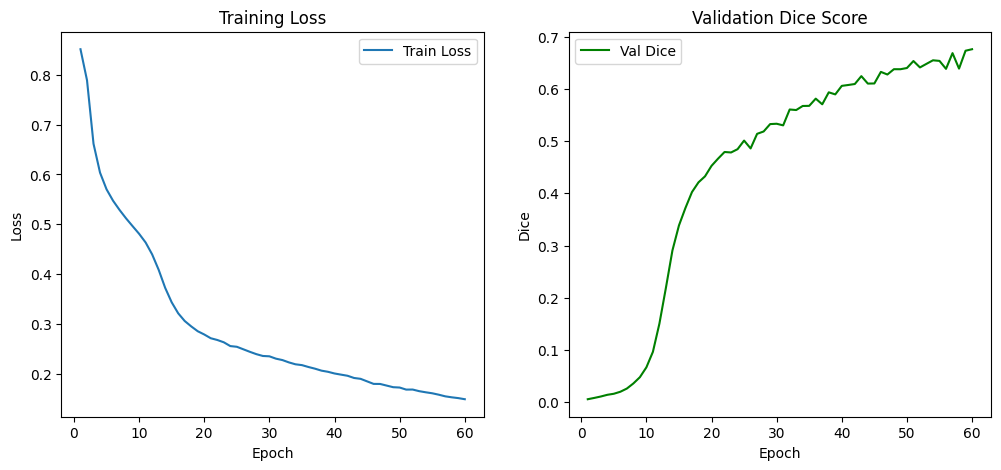

In [15]:
history_df = pd.read_csv(OUTPUT_DIR / "training_history.csv")
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_df["epoch"], history_df["train_loss"], label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_df["epoch"], history_df["val_dice"], label="Val Dice", color="green")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.title("Validation Dice Score"); plt.legend()
plt.savefig(OUTPUT_DIR/"loss_dice_curve_unet.png", dpi=300, bbox_inches='tight')
plt.show()


# Inference

In [20]:
import numpy as np
from scipy.ndimage import label, find_objects
import SimpleITK as sitk
import torch
import numpy as np
import torch.nn.functional as F

def load_ct_patch_as_tensor(path, size=64):
    """
    Loads a .nii.gz patch, normalizes, pads/crops to 64³,
    and returns tensor (1,1,64,64,64)
    """
    img = sitk.ReadImage(path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)  # (Z,Y,X)

    # ----- same normalization as training -----
    arr = np.clip(arr, -1000, 400)
    arr = (arr + 1000) / 1400

    # convert to tensor
    t = torch.tensor(arr).unsqueeze(0).unsqueeze(0)  # (1,1,Z,Y,X)

    Z,Y,X = t.shape[-3:]

    # ------- pad or crop to exactly 64³ -------
    padZ = max(0, size - Z)
    padY = max(0, size - Y)
    padX = max(0, size - X)

    t = F.pad(t, (0,padX, 0,padY, 0,padZ), mode="constant", value=0)
    t = t[:, :, :size, :size, :size]   # crop if too large

    return t  # final (1,1,64,64,64)


def get_bbox_from_mask(mask):
    """
    mask: numpy array (Z,Y,X) with values 0/1
    returns (z1,z2,y1,y2,x1,x2)
    """
    labeled, num = label(mask)
    if num == 0:
        return None

    # find largest connected component
    sizes = [(labeled == i).sum() for i in range(1, num+1)]
    largest = np.argmax(sizes) + 1

    obj = find_objects(labeled == largest)[0]
    z1,z2 = obj[0].start, obj[0].stop
    y1,y2 = obj[1].start, obj[1].stop
    x1,x2 = obj[2].start, obj[2].stop

    return (z1,z2, y1,y2, x1,x2)

def compute_diameter_mm(mask, spacing=(1.0,1.0,1.0)):
    """
    mask: numpy array (Z,Y,X) with 0/1
    spacing: (z_spacing, y_spacing, x_spacing)
    Returns equivalent spherical diameter in mm.
    """
    voxels = np.sum(mask > 0)
    if voxels == 0:
        return 0.0

    voxel_volume_mm3 = spacing[0] * spacing[1] * spacing[2]
    volume_mm3 = voxels * voxel_volume_mm3

    # Convert volume to equivalent sphere diameter
    diameter_mm = ( (6 * volume_mm3 / np.pi) ** (1/3) )
    return diameter_mm

# Confidence = 0.5 × mean_prob + 0.5 × Dice
def compute_confidence(pred_prob, mask):
    if mask.sum() == 0:
        return 0.0

    mean_prob = float(pred_prob[mask > 0].mean())

    hard_pred = (pred_prob > 0.5).astype(float)
    intersection = (hard_pred * mask).sum()
    union = hard_pred.sum() + mask.sum()
    dice = (2 * intersection) / (union + 1e-8)

    return float(0.5 * mean_prob + 0.5 * dice)


def predict_nodule_info(model, img_tensor, device="cuda"):
    """
    img_tensor: (1,1,64,64,64)
    """
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor.to(device))
        pred_prob = torch.sigmoid(pred).cpu().numpy()[0,0]     # (64,64,64)

    # threshold
    mask = (pred_prob > 0.5).astype(np.uint8)

    # bounding box
    bbox = get_bbox_from_mask(mask)

    # compute diameter mm
    spacing = (1.0, 1.0, 1.0)   # your patches are isotropic 1mm now
    diameter = compute_diameter_mm(mask, spacing)

    # confidence
    conf = compute_confidence(pred_prob, mask)

    return {
        "mask": mask,
        "bbox": bbox,
        "diameter_mm": diameter,
        "confidence": conf
    }

def visualize_bbox(image_np, bbox, confidence, diameter_mm):
    """
    image_np:      (64,64,64) numpy volume
    bbox:          (zmin, zmax, ymin, ymax, xmin, xmax)
    confidence:    float (0–1)
    diameter_mm:   float
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # pick middle slice for 2D visualization
    mid = image_np.shape[0] // 2
    img_slice = image_np[mid]

    zmin, zmax, ymin, ymax, xmin, xmax = bbox

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img_slice, cmap="gray")
    ax.set_title("Bounding Box + Info")

    # Draw bounding box (only XY projection)
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='yellow',
        facecolor='none',
    )
    ax.add_patch(rect)

    # --------- NEW TEXT DISPLAY ---------
    text = f"Confidence: {confidence*100:.1f}%\nDiameter: {diameter_mm:.2f} mm"
    ax.text(
        xmin,
        ymin - 5,
        text,
        color="yellow",
        fontsize=12,
        backgroundcolor="black",
    )

    plt.show()



In [21]:
from monai.networks.nets import UNet
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16,32,64,128),
    strides=(2,2,2),
    num_res_units=2
).to(device)

ckpt = torch.load("../models/3d_unet/unet_best.pt", map_location=device)
unet.load_state_dict(ckpt["model_state_dict"])
unet.eval()

print("UNet loaded successfully!")

UNet loaded successfully!


In [22]:
nii_path = "../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279_6001_321465552859463184018938648244_0886.nii.gz"

img_tensor = load_ct_patch_as_tensor(nii_path)   # → (1,1,64,64,64)

result = predict_nodule_info(unet, img_tensor)

In [23]:
result

{'mask': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0

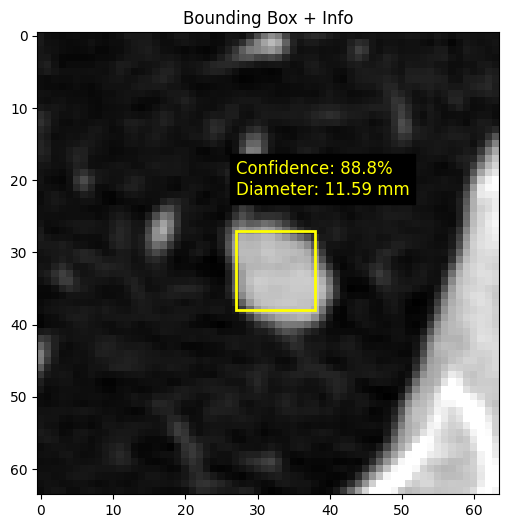

In [24]:
visualize_bbox(
    img_tensor.cpu().numpy()[0,0],   # (64,64,64)
    result["bbox"],
     result["confidence"],
result["diameter_mm"],

)
